In [2]:
# import packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import tensorflow as tf
import math


# NN
import keras

from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50, MobileNetV2, ResNet101V2
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from tensorflow.keras.layers import BatchNormalization


In [3]:
# NORMAL
image_folder_normal = 'chest_xray/chest_xray/train/NORMAL/'

# List all image files in the folder
image_files_normal = sorted([f for f in os.listdir(image_folder_normal) if f.endswith(('jpeg'))])

# Initialize lists to store file names and image data
vec_normal = []
image_arrays_normal = []

# Loop through each image file and process
for image_file in image_files_normal:
    # Load image
    img = Image.open(os.path.join(image_folder_normal, image_file))
    img = img.resize((224, 224)) 
    img = img.convert('L')

    # Convert image to numpy array
    img_array = np.array(img)
    image_arrays_normal.append(img_array)
    vec_normal.append(image_file)

# Create a pandas DataFrame
df_normal = pd.DataFrame({
    'file_name': [image_folder_normal + item for item in vec_normal],
    'image_array': image_arrays_normal,
    'label': 'NORMAL'
})

# BACTERIA

image_folder_pneumonia = 'chest_xray/chest_xray/train/PNEUMONIA/'

# List all image files in the folder
image_files_bacteria = sorted([f for f in os.listdir(image_folder_pneumonia) if f.endswith(('jpeg')) and 'bacteria' in f.lower()])

# Initialize lists to store file names and image data
vec_bacteria = []
image_arrays_bacteria = []

# Loop through each image file and process
for image_file in image_files_bacteria:
    # Load image
    img = Image.open(os.path.join(image_folder_pneumonia, image_file))
    img = img.resize((224, 224)) 
    img = img.convert('L')
    # Convert image to numpy array
    img_array = np.array(img)
    image_arrays_bacteria.append(img_array)

    # Append file name and image data to lists
    vec_bacteria.append(image_file)

# Create a pandas DataFrame
df_bacteria = pd.DataFrame({
    'file_name': [image_folder_pneumonia + item for item in vec_bacteria],
    'image_array': image_arrays_bacteria,
    'label': 'BACTERIA'
})

# VIRUS

image_files_virus = sorted([f for f in os.listdir(image_folder_pneumonia) if f.endswith(('jpeg')) and 'virus' in f.lower()])

# Initialize lists to store file names and image data
file_names_virus = []
image_arrays_virus = []

# Loop through each image file and process
for image_file in image_files_virus:
    # Load image
    img = Image.open(os.path.join(image_folder_pneumonia, image_file))
    img = img.resize((224, 224)) 
    img = img.convert('L')
    # Convert image to numpy array
    img_array = np.array(img)
    image_arrays_virus.append(img_array)

    # Append file name and image data to lists
    file_names_virus.append(image_file)

# Create a pandas DataFrame
df_virus = pd.DataFrame({
    'file_name': [image_folder_pneumonia + item for item in file_names_virus],
    'image_array': image_arrays_virus,
    'label': 'VIRUS'
})

df_combined = pd.DataFrame({
    'file_name': df_normal['file_name'].tolist() + df_bacteria['file_name'].tolist() + df_virus['file_name'].tolist(),
    'image_array': df_normal['image_array'].tolist() + df_bacteria['image_array'].tolist() + df_virus['image_array'].tolist(),
    'label': df_normal['label'].tolist() + df_bacteria['label'].tolist() + df_virus['label'].tolist()
})

# Data 1

# Full Model and Variance

$$
\hat{V} = \frac{1}{n^2} \sum_{i=1}^{n} \hat{\gamma}_i^2 \left(  Y_i- \hat{m}_i(X_i) \right)^2
$$

In [200]:
# Calculation Functions

def brightness_f(x):
  return np.array([np.mean(i) for i in x])

def inv_logit(x):
  return 1 / (1 + np.exp(-x))

def propensity_score(x):
  return inv_logit((1/10)*(x-123))

def assign(x, y_1 = 1, y_0 = 0):
  p = propensity_score(x)
  w = np.random.binomial(1, p)
  y1 = y_1 + p
  y0 = y_0 + p
  return p, w, y1, y0

bright_matrix = df_combined['image_array']
X = brightness_f(bright_matrix)
P, W, Y1, Y0 = assign(X)
Y = W*Y1 + (1-W)*Y0
np.random.seed(0)
random_index = np.random.choice(range(5216), 200, replace=False)
X_0 = X[random_index]
P_0 = P[random_index]
W_0 = W[random_index]
Y1_0 = Y1[random_index]
Y0_0 = Y0[random_index]

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)


In [5]:
set_seed(0)
def modeling():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

df_combined['Y'] = Y
df_combined['W'] = W
df_combined['P'] = P

X_full = np.array([np.array(x) for x in bright_matrix])
y_full = df_combined['Y'].values

N=5216
model_full = modeling()
model_full.fit(X_full, y_full, epochs=5, batch_size=16, validation_split=0.2, shuffle=True)
y_pred = model_full.predict(X_full)

/Users/wangzijian/Desktop/HONOR/python_honor/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-05 23:04:41.457658: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-05 23:04:41.458039: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-05 23:04:41.458057: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-05 23:04:41.458358: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-05 23:04:41.458670: I tensorflow/core/common_runtime/pluggable_device/plu

Epoch 1/5


2025-04-05 23:04:42.381062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 4.3922 - val_loss: 0.3353
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.3787 - val_loss: 0.3109
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.3515 - val_loss: 0.3112
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.3356 - val_loss: 0.2917
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.3172 - val_loss: 0.3163
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


# Minimax

In [201]:
psi = np.zeros((len(X_0), 3))
psi[:, 0]=1
psi[:, 1]=X_0
psi[:, 2]=X_0**2

n = len(X_0)
A = np.zeros((6, n))
b = np.zeros(6)

for i in range(n):
    A[:3, i] = psi[i] * (1 - W_0[i])
    A[3:, i] = psi[i] * W_0[i]
    b[:3] += -psi[i]
    b[3:] += psi[i]

A = A/n
b = b/n

lambda_reg = 1

AT_A = np.dot(A.T, A) + lambda_reg * np.eye(A.shape[1])
AT_b = np.dot(A.T, b)
gamma_mini = np.linalg.solve(AT_A, AT_b)
Y_0 = W_0 * Y1_0 + (1 - W_0) * Y0_0
ipw_mini = np.mean(gamma_mini * Y_0)
print(ipw_mini)



0.983450004227081


In [203]:
lambda_reg2 = 2.5e-5

AT_A = np.dot(A.T, A) + lambda_reg2 * np.eye(A.shape[1])
AT_b = np.dot(A.T, b)
gamma_mini2 = np.linalg.solve(AT_A, AT_b)
Y_0 = W_0 * Y1_0 + (1 - W_0) * Y0_0
ipw_mini2 = np.mean(gamma_mini2 * Y_0)
print(ipw_mini2)

1.012301267405481


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/619018611.py:2: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/619018611.py:3: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


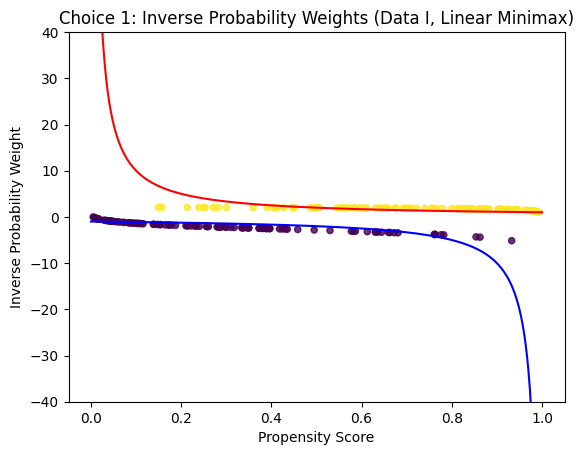

In [204]:
x_vals = np.linspace(0, 1, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, gamma_mini, c = W_0,alpha = .8, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Choice 1: Inverse Probability Weights (Data I, Linear Minimax)')
plt.ylim(-40, 40)
plt.show()

/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/2588312443.py:2: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/2588312443.py:3: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


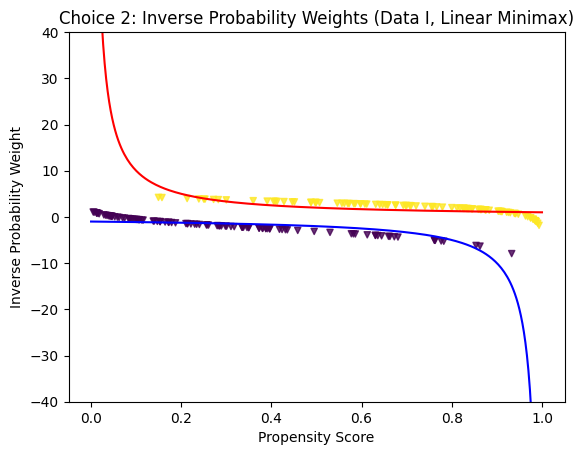

In [205]:
x_vals = np.linspace(0, 1, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, gamma_mini2, c = W_0,alpha = .8, s = 20, marker='v')
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Choice 2: Inverse Probability Weights (Data I, Linear Minimax)')
plt.ylim(-40, 40)
plt.show()

In [206]:
# # x = np.array(range(0,220))
# # plt.scatter(X_0, gamma_mini, c = W_0,alpha = .5, s = 10)
# # plt.plot(x, 1/(propensity_score(x)), color = 'red')
# # plt.plot(x, 1/((propensity_score(x)-1)), color = 'blue')
# # plt.title('Inverse Probability Weights (Data I, Linear Minimax)')
# # plt.ylim(-40,40)

# # Generate smooth lines
# # Theoretical curves
# x_vals = np.linspace(0.01, 0.99, 300)
# inv_p = 1 / x_vals
# inv_1_minus_p = 1 / (x_vals - 1)
# treated_mask = W_0 == 1
# control_mask = W_0 == 0

# plt.scatter(P_0[treated_mask], gamma_mini[treated_mask], 
#             c='blue', marker='o', s=25, alpha=0.3, label='Gamma Minimax 1 (Treated)')
# plt.scatter(P_0[control_mask], gamma_mini[control_mask],
#             c='red', marker='s', s=25, alpha=0.3, label='Gamma Minimax 1 (Control)')
# plt.scatter(P_0[treated_mask], gamma_mini2[treated_mask], 
#             c='green', marker='X', s=25, alpha=0.3, label='Gamma Minimax 2 (Treated)')
# plt.scatter(P_0[control_mask], gamma_mini2[control_mask], 
#             c='orange', marker='^', s=25, alpha=0.3, label='Gamma Minimax 2 (Control)')

# # Plot theoretical reference curves
# plt.plot(x_vals, inv_p, color='red')
# plt.plot(x_vals, inv_1_minus_p, color='blue')

# # Formatting
# plt.xlabel('Propensity Score', fontsize=12)
# plt.ylabel('Inverse Probability Weight', fontsize=12)
# plt.title('Inverse Probability Weights (Data I, Linear Minimax)', fontsize=14)
# plt.ylim(-20, 20)
# plt.legend()
# plt.show()

In [207]:
pes_mini = []
se_mini = []
coverage_flags = []
N = 5216
n = 200

for s in range(0, 100):  # outer loop: sample subsets
    np.random.seed(s)
    i = np.random.choice(range(5216), 200, replace=False)
    X_0s = np.array(X[i])
    W_0s = np.array(W[i])
    Y1_0s = np.array(Y1[i])
    Y0_0s = np.array(Y0[i])

    # construct psi (basis functions)
    psi = np.zeros((len(X_0s), 3))
    psi[:, 0] = 1
    psi[:, 1] = X_0s
    psi[:, 2] = X_0s ** 2

    # build design matrix A and vector b
    n = len(X_0s)
    A = np.zeros((6, n))
    b = np.zeros(6)
    for k in range(n):
        A[:3, k] = psi[k] * (1 - W_0s[k])
        A[3:, k] = psi[k] * W_0s[k]
        b[:3] += -psi[k]
        b[3:] += psi[k]
    A = A / n
    b = b / n

    # solve minimax gamma
    lambda_reg = 1
    AT_A = np.dot(A.T, A) + lambda_reg * np.eye(A.shape[1])
    AT_b = np.dot(A.T, b)
    gamma_mini = np.linalg.solve(AT_A, AT_b)

    # compute IPW estimate
    Y_fulls = W_0s * Y1_0s + (1 - W_0s) * Y0_0s
    ipw_estimate = np.mean(gamma_mini * Y_fulls)
    pes_mini.append(ipw_estimate)

    # compute variance estimator
    y_preds = y_pred[i]
    v_sum = gamma_mini**2 * (Y_fulls - y_preds) ** 2
    v_hat = (1 / N**2) * np.sum(v_sum)
    se_hat = np.sqrt(v_hat)
    se_mini.append(se_hat)


# convert to arrays and summarize
pes_mini = np.array(pes_mini)
se_mini = np.array(se_mini)
exppes = np.mean(pes_mini)
samplestd1 = np.std(pes_mini)
true_arm_l, true_arm_r = 1 - 1.96*samplestd1, 1+1.96*samplestd1
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes_mini]
coverage = np.mean(coverage_flags)
expstd = np.mean(se_mini)
true_arm_l, true_arm_r = 1-1.96 * np.std(pes_mini), 1 + 1.96 * np.std(pes_mini)

print('coverage:', coverage)
print('sample std:', samplestd1)
print('expected std:', expstd)
print('expected pes:', exppes)
print('true arm:', true_arm_l, true_arm_r)
print('exp estimate:', np.mean(pes_mini))


coverage: 0.94
sample std: 0.017502360265297084
expected std: 0.06030651051775528
expected pes: 0.997774682198126
true arm: 0.9656953738800177 1.0343046261199822
exp estimate: 0.997774682198126


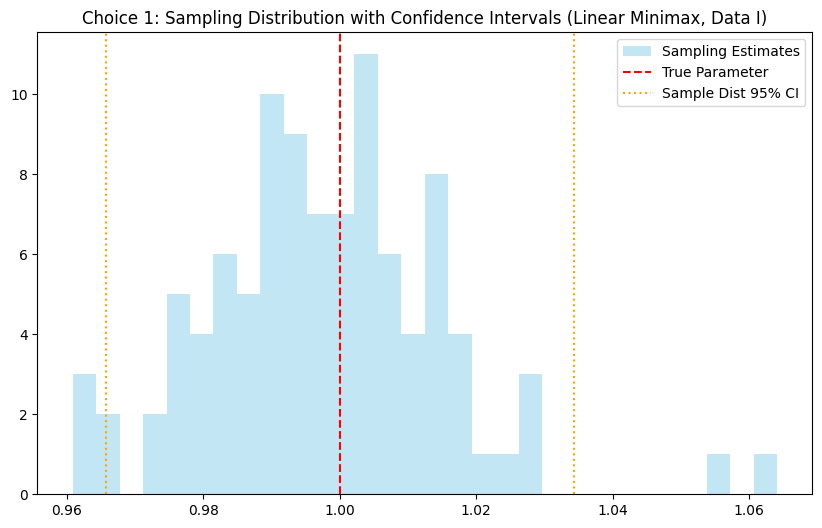

In [208]:
plt.figure(figsize=(10, 6))
plt.hist(pes_mini, bins=30, alpha=0.5, color='skyblue', label='Sampling Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(pes_mini, se_mini)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/15, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1, label=label)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 1: Sampling Distribution with Confidence Intervals (Linear Minimax, Data I)')

plt.legend()
plt.show()

In [209]:
pes_mini = []
se_mini = []
coverage_flags = []
N = 5216
n = 200

for s in range(0, 100):  # outer loop: sample subsets
    np.random.seed(s)
    i = np.random.choice(range(5216), 200, replace=False)
    X_0s = np.array(X[i])
    W_0s = np.array(W[i])
    Y1_0s = np.array(Y1[i])
    Y0_0s = np.array(Y0[i])

    # construct psi (basis functions)
    psi = np.zeros((len(X_0s), 3))
    psi[:, 0] = 1
    psi[:, 1] = X_0s
    psi[:, 2] = X_0s ** 2

    # build design matrix A and vector b
    n = len(X_0s)
    A = np.zeros((6, n))
    b = np.zeros(6)
    for k in range(n):
        A[:3, k] = psi[k] * (1 - W_0s[k])
        A[3:, k] = psi[k] * W_0s[k]
        b[:3] += -psi[k]
        b[3:] += psi[k]
    A = A / n
    b = b / n

    # solve minimax gamma
    lambda_reg = 2.5e-5
    AT_A = np.dot(A.T, A) + lambda_reg * np.eye(A.shape[1])
    AT_b = np.dot(A.T, b)
    gamma_mini = np.linalg.solve(AT_A, AT_b)

    # compute IPW estimate
    Y_fulls = W_0s * Y1_0s + (1 - W_0s) * Y0_0s
    ipw_estimate = np.mean(gamma_mini * Y_fulls)
    pes_mini.append(ipw_estimate)

    # compute variance estimator
    y_preds = y_pred[i]
    v_sum = gamma_mini**2 * (Y_fulls - y_preds) ** 2
    v_hat = (1 / N**2) * np.sum(v_sum)
    se_hat = np.sqrt(v_hat)
    se_mini.append(se_hat)


# convert to arrays and summarize
pes_mini = np.array(pes_mini)
se_mini = np.array(se_mini)
exppes = np.mean(pes_mini)
samplestd1 = np.std(pes_mini)
true_arm_l, true_arm_r = 1 - 1.96*samplestd1, 1+1.96*samplestd1
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes_mini]
coverage = np.mean(coverage_flags)
expstd = np.mean(se_mini)
true_arm_l, true_arm_r = 1-1.96 * np.std(pes_mini), 1 + 1.96 * np.std(pes_mini)

print('coverage:', coverage)
print('sample std:', samplestd1)
print('expected std:', expstd)
print('expected pes:', exppes)
print('true arm:', true_arm_l, true_arm_r)
print('exp estimate:', np.mean(pes_mini))


coverage: 0.86
sample std: 0.010554031363866758
expected std: 0.06457149464832738
expected pes: 1.0106315332138842
true arm: 0.9793140985268212 1.0206859014731788
exp estimate: 1.0106315332138842


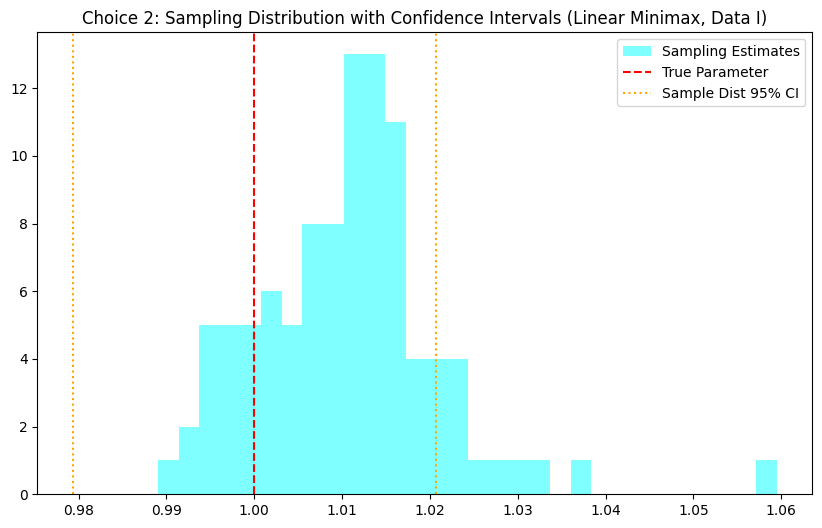

In [210]:
plt.figure(figsize=(10, 6))
plt.hist(pes_mini, bins=30, alpha=0.5, color='cyan', label='Sampling Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(pes_mini, se_mini)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/15, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1, label=label)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 2: Sampling Distribution with Confidence Intervals (Linear Minimax, Data I)')

plt.legend()
plt.show()

$$
B_s = p^k, k\in \{-1,-3/4, -1/2,-1/4,0,1/4,1/2,3/4,1\}
$$

In [211]:
# p selection
# p = -1, -1/2, 0, 1/2, 1, 3/2, 2

rmsev = []
biasv = []
p_mini = 200
sigma = 1
Bsv = []
coveragev = []
for p in [-1, -3/4, -1/2, -1/4, 0, 1/4, 1/2]:
    Bs = p_mini**p
    Bsv.append(Bs)
    pes_mini = []
    se_mini = []
    coverage_flags = []
    lamb = sigma**2/(Bs**2*200**2)
    for s in range(0, 100):  # outer loop: sample subsets
        np.random.seed(s)
        i = np.random.choice(range(5216), 200, replace=False)
        X_0s = np.array(X[i])
        W_0s = np.array(W[i])
        Y1_0s = np.array(Y1[i])
        Y0_0s = np.array(Y0[i])

    # construct psi (basis functions)
        psi = np.zeros((len(X_0s), 3))
        psi[:, 0] = 1
        psi[:, 1] = X_0s
        psi[:, 2] = X_0s ** 2

    # build design matrix A and vector b
        n = len(X_0s)
        A = np.zeros((6, n))
        b = np.zeros(6)
        for k in range(n):
            A[:3, k] = psi[k] * (1 - W_0s[k])
            A[3:, k] = psi[k] * W_0s[k]
            b[:3] += -psi[k]
            b[3:] += psi[k]
        A = A / n
        b = b / n

    # solve minimax gamma
        lambda_reg = lamb
        AT_A = np.dot(A.T, A) + lambda_reg * np.eye(A.shape[1])
        AT_b = np.dot(A.T, b)
        gamma_mini = np.linalg.solve(AT_A, AT_b)

    # compute IPW estimate
        Y_fulls = W_0s * Y1_0s + (1 - W_0s) * Y0_0s
        ipw_estimate = np.mean(gamma_mini * Y_fulls)
        pes_mini.append(ipw_estimate)

    # compute variance estimator
        y_preds = y_pred[i]
        v_sum = gamma_mini**2 * (Y_fulls - y_preds) ** 2
        v_hat = (1 / N**2) * np.sum(v_sum)
        se_hat = np.sqrt(v_hat)
        se_mini.append(se_hat)


# convert to arrays and summarize
    pes_mini = np.array(pes_mini)
    se_mini = np.array(se_mini)
    exppes = np.mean(pes_mini)
    samplestd = np.std(pes_mini)
    true_arm_l, true_arm_r = 1 - 1.96*samplestd, 1+1.96*samplestd
    coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes_mini]
    coverage = np.mean(coverage_flags)
    expstd = np.mean(se_mini)
    true_arm_l, true_arm_r = 1-1.96 * np.std(pes_mini), 1 + 1.96 * np.std(pes_mini)
    rmse = np.sqrt(np.mean((pes_mini - 1)**2))
    bias = np.abs(np.mean(pes_mini - 1))

    print('k', p)
    print('Bs:', Bs)
    print('lambda:', lamb)
    print('coverage:', coverage)
    print('sample std:', samplestd)
    print('expected pes:', exppes)
    print('bias:', bias)
    print('bias/rmse:', bias/rmse)  
    print('---')

    rmsev.append(rmse)
    biasv.append(bias)
    coveragev.append(coverage)


    


k -1
Bs: 0.005
lambda: 1.0
coverage: 0.94
sample std: 0.017502360265297084
expected pes: 0.997774682198126
bias: 0.002225317801873884
bias/rmse: 0.12612848713718305
---
k -0.75
Bs: 0.018803015465431967
lambda: 0.07071067811865477
coverage: 0.85
sample std: 0.011232063104780334
expected pes: 1.0133047996407283
bias: 0.013304799640728069
bias/rmse: 0.7641176998914173
---
k -0.5
Bs: 0.07071067811865475
lambda: 0.005
coverage: 0.81
sample std: 0.010911128038705854
expected pes: 1.014607320828198
bias: 0.014607320828197982
bias/rmse: 0.801166396673234
---
k -0.25
Bs: 0.26591479484724945
lambda: 0.0003535533905932737
coverage: 0.82
sample std: 0.01093275470457687
expected pes: 1.0144018427566324
bias: 0.01440184275663229
bias/rmse: 0.7964989930651306
---
k 0
Bs: 1
lambda: 2.5e-05
coverage: 0.86
sample std: 0.010554031363866758
expected pes: 1.0106315332138842
bias: 0.010631533213884261
bias/rmse: 0.7096887977413505
---
k 0.25
Bs: 3.7606030930863934
lambda: 1.7677669529663689e-06
coverage: 0.

In [212]:
coverage_levels = {
    "95%": 0.00606,
    "90%": 0.54640,
    "80%": 0.74434,
    "70%": 0.82037
}

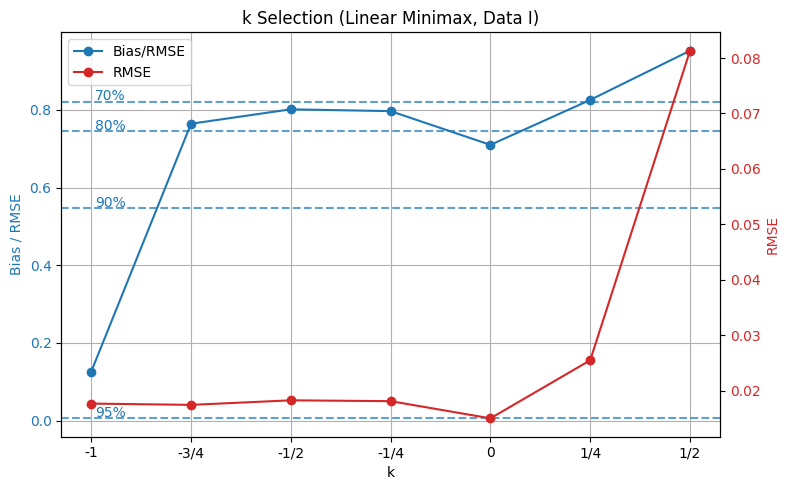

In [213]:
# plt.plot(np.log(Bsv), rmsev, marker='o', label='RMSE')
# plt.plot(np.log(Bsv), biasv/rmse, marker='o', label='Bias/RMSE')
# plt.title('k selection (Linear Minimax, Data I)')
# plt.xticks(np.log(Bsv), ['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2'])
# plt.grid()
# plt.xlabel('B')
# plt.legend()
# plt.show()
biasoverrmse = np.array(biasv)/np.array(rmsev)  

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Bias / RMSE
color1 = 'tab:blue'
line1, = ax1.plot(np.log(Bsv), biasoverrmse, marker='o', color=color1, label='Bias/RMSE')
ax1.set_xlabel('k')
ax1.set_ylabel('Bias / RMSE', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# X-axis ticks
ax1.set_xticks(np.log(Bsv))
ax1.set_xticklabels(['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2'])

# Add horizontal lines for coverage levels
for label, threshold in coverage_levels.items():
    ax1.axhline(y=threshold, color=color1, linestyle='--', alpha=0.7)
    ax1.text(np.log(Bsv[0]) + 0.05, threshold+0.015, label,
             va='center', ha='left', fontsize=10, color=color1)

# Secondary y-axis for RMSE
ax2 = ax1.twinx()
color2 = 'tab:red'
line2, = ax2.plot(np.log(Bsv), rmsev, marker='o', color=color2, label='RMSE')
ax2.set_ylabel('RMSE', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Title, grid, and layout
plt.title('k Selection (Linear Minimax, Data I)')
ax1.grid(True)
plt.tight_layout()
plt.show()

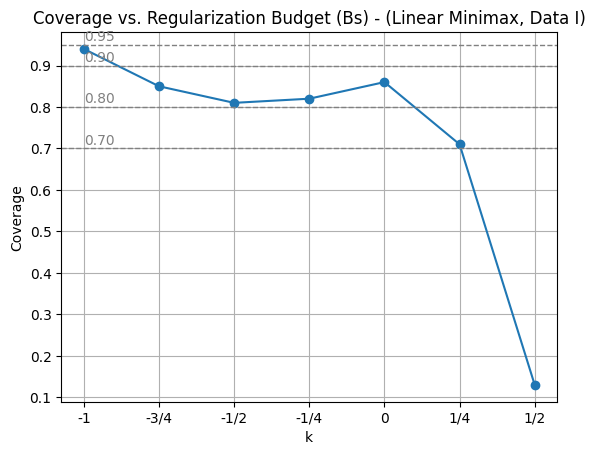

In [214]:
# coverage
plt.plot(np.log(Bsv), coveragev, marker='o', label='Coverage')
# Add horizontal reference lines at common confidence levels
for level in [0.7, 0.8, 0.9, 0.95]:
    plt.axhline(y=level, color='gray', linestyle='--', linewidth=1)
    plt.text(np.log(Bsv)[0], level + 0.01, f'{level:.2f}', color='gray')
# Customize the plot
plt.xlabel('k')
plt.ylabel('Coverage')
plt.title('Coverage vs. Regularization Budget (Bs) - (Linear Minimax, Data I)')
plt.grid(True)
plt.xticks(np.log(Bsv), ['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2'])
plt.show()


Minimax k selection: k = -3/4, Bs = p^(-3/4) = 0.018803015465431967, lambda = 7.071067811865477e-06

## RBF

In [215]:
from scipy.spatial.distance import cdist

def kernel_with_masking(W, X, sw, s, sigma):
    WX = np.stack([W * sw, X / s], axis=1)
    WX_0 = np.stack([np.zeros_like(W), X / s], axis=1)
    WX_1 = np.stack([np.ones_like(W) * sw, X / s], axis=1)

    K_XX = np.exp(-cdist(WX, WX, 'sqeuclidean') / (2 * sigma**2))
    K_X1 = np.exp(-cdist(WX, WX_1, 'sqeuclidean') / (2 * sigma**2)) @ np.ones((len(X), 1))
    K_X0 = np.exp(-cdist(WX, WX_0, 'sqeuclidean') / (2 * sigma**2)) @ np.ones((len(X), 1))
    same_w_mask = (W[:, None] == W[None, :]) 
    K_XX_masked = K_XX * same_w_mask

    K_Xdiff = K_X1 - K_X0

    return K_XX_masked, K_Xdiff

n = 5216
sw = 1
s = np.mean(X_0)
sigma2 = 0.25
K_XX_masked, K_Xdiff = kernel_with_masking(W_0, X_0, sw, s, sigma=sigma2)
I = np.eye(K_XX_masked.shape[0])
lambda_reg = 0.005

gamma_rbf = (np.linalg.solve(K_XX_masked + lambda_reg * I, (K_Xdiff))).flatten()
Y_fulls = W_0 * Y1_0 + (1 - W_0) * Y0_0
ipw_rbf = np.mean(gamma_rbf* Y_fulls)
print("IPW estimate:", ipw_rbf)

IPW estimate: 0.9975577030888015


In [216]:
I = np.eye(K_XX_masked.shape[0])
lambda_reg = 2.5e-5

gamma_rbf2 = (np.linalg.solve(K_XX_masked + lambda_reg * I, (K_Xdiff))).flatten()
Y_fulls = W_0 * Y1_0 + (1 - W_0) * Y0_0
ipw_rbf2 = np.mean(gamma_rbf2* Y_fulls)
print("IPW estimate:", ipw_rbf2)

IPW estimate: 1.0017717506631032


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/1526804878.py:2: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/1526804878.py:3: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


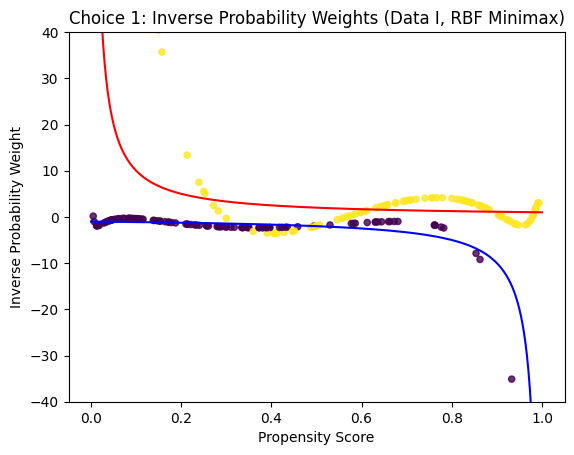

In [217]:
x_vals = np.linspace(0, 1, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, gamma_rbf, c = W_0,alpha = .8, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Choice 1: Inverse Probability Weights (Data I, RBF Minimax)')
plt.ylim(-40, 40)
plt.show()


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/4135471120.py:2: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/4135471120.py:3: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


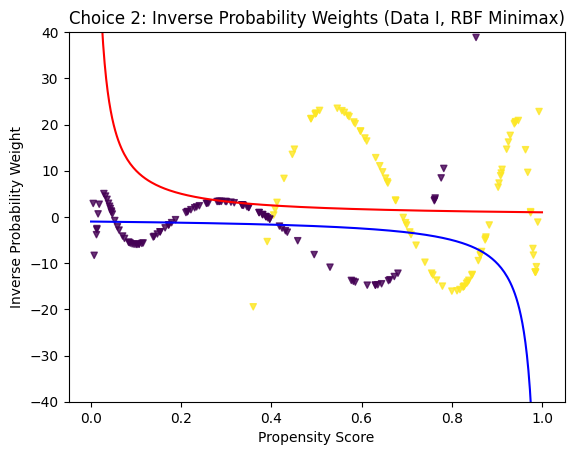

In [218]:
x_vals = np.linspace(0, 1, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, gamma_rbf2, c = W_0,alpha = .8, s = 20, marker='v')
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Choice 2: Inverse Probability Weights (Data I, RBF Minimax)')
plt.ylim(-40, 40)
plt.show()


In [219]:
pes_rbf = []
se_rbf = []
coverage_flags = []
N = 5216
n = 200
sigma2 = 0.25
lambda_reg = 0.005

for s in range(100):  # outer loop: sample subsets
    np.random.seed(s)
    i = np.random.choice(range(N), n, replace=False)
    X_0s = np.array(X[i])
    W_0s = np.array(W[i])
    Y1_0s = np.array(Y1[i])
    Y0_0s = np.array(Y0[i])
    y_preds = y_pred[i]

    # RBF kernel matrix and target vector
    sw = 1
    s_avg = np.mean(X_0s)
    K_XX_masked, K_Xdiff = kernel_with_masking(W_0s, X_0s, sw, s_avg, sigma=sigma2)
    I = np.eye(n)

    # solve for gamma using ridge regularization
    gamma_rbf = np.linalg.solve(K_XX_masked + lambda_reg * I, K_Xdiff).flatten()

    # IPW estimate
    Y_fulls = W_0s * Y1_0s + (1 - W_0s) * Y0_0s
    ipw_estimate = np.mean(gamma_rbf * Y_fulls)
    pes_rbf.append(ipw_estimate)

    # Variance estimate
    v_sum = gamma_rbf**2 * (Y_fulls - y_preds) ** 2
    v_hat = (1 / N**2) * np.sum(v_sum)
    se_hat = np.sqrt(v_hat)
    se_rbf.append(se_hat)

# Summarize sampling distribution
pes_rbf = np.array(pes_rbf)
se_rbf = np.array(se_rbf)
exppes = np.mean(pes_rbf)
samplestd1 = np.std(pes_rbf)
true_arm_l, true_arm_r = 1 - 1.96 * samplestd1, 1 + 1.96 * samplestd1
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes_rbf]
coverage = np.mean(coverage_flags)
expstd = np.mean(se_rbf)

print('coverage:', coverage)
print('sample std:', samplestd1)
print('expected std:', expstd)
print('expected pes:', exppes)
print('exp estimate:', np.mean(pes_rbf))

coverage: 0.93
sample std: 0.008058128065671374
expected std: 0.09145553620132904
expected pes: 1.0043016769073956
exp estimate: 1.0043016769073956


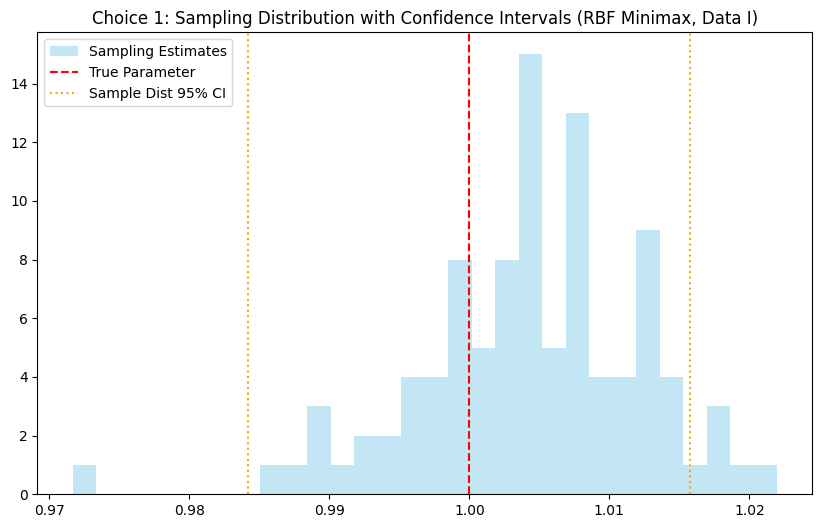

In [220]:
plt.figure(figsize=(10, 6))
plt.hist(pes_rbf, bins=30, alpha=0.5, color='skyblue', label='Sampling Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(pes_rbf, se_mini)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1, label=label)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 1: Sampling Distribution with Confidence Intervals (RBF Minimax, Data I)')

plt.legend()
plt.show()

In [221]:
pes_rbf = []
se_rbf = []
coverage_flags = []
N = 5216
n = 200
sigma2 = 0.25
lambda_reg = 2.5e-5

for s in range(100):  # outer loop: sample subsets
    np.random.seed(s)
    i = np.random.choice(range(N), n, replace=False)
    X_0s = np.array(X[i])
    W_0s = np.array(W[i])
    Y1_0s = np.array(Y1[i])
    Y0_0s = np.array(Y0[i])
    y_preds = y_pred[i]

    # RBF kernel matrix and target vector
    sw = 1
    s_avg = np.mean(X_0s)
    K_XX_masked, K_Xdiff = kernel_with_masking(W_0s, X_0s, sw, s_avg, sigma=sigma2)
    I = np.eye(n)

    # solve for gamma using ridge regularization
    gamma_rbf = np.linalg.solve(K_XX_masked + lambda_reg * I, K_Xdiff).flatten()

    # IPW estimate
    Y_fulls = W_0s * Y1_0s + (1 - W_0s) * Y0_0s
    ipw_estimate = np.mean(gamma_rbf * Y_fulls)
    pes_rbf.append(ipw_estimate)

    # Variance estimate
    v_sum = gamma_rbf**2 * (Y_fulls - y_preds) ** 2
    v_hat = (1 / N**2) * np.sum(v_sum)
    se_hat = np.sqrt(v_hat)
    se_rbf.append(se_hat)

# Summarize sampling distribution
pes_rbf = np.array(pes_rbf)
se_rbf = np.array(se_rbf)
exppes = np.mean(pes_rbf)
samplestd1 = np.std(pes_rbf)
true_arm_l, true_arm_r = 1 - 1.96 * samplestd1, 1 + 1.96 * samplestd1
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes_rbf]
coverage = np.mean(coverage_flags)
expstd = np.mean(se_rbf)

print('coverage:', coverage)
print('sample std:', samplestd1)
print('expected std:', expstd)
print('expected pes:', exppes)
print('exp estimate:', np.mean(pes_rbf))

coverage: 0.89
sample std: 0.009299419714351227
expected std: 0.3537602132067776
expected pes: 1.0043977173673824
exp estimate: 1.0043977173673824


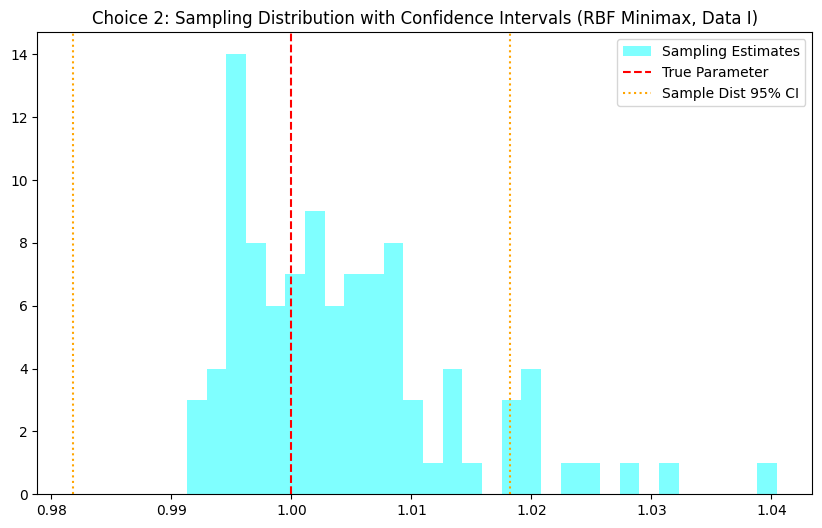

In [222]:
plt.figure(figsize=(10, 6))
plt.hist(pes_rbf, bins=30, alpha=0.5, color='cyan', label='Sampling Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(pes_rbf, se_mini)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1, label=label)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 2: Sampling Distribution with Confidence Intervals (RBF Minimax, Data I)')

plt.legend()
plt.show()

In [223]:
rmsev = []
biasv = []
p_rbf = 200
sigma = 1
Bsv = []
coveragev = []
for p in [-1, -3/4, -1/2, -1/4, 0, 1/4, 1/2]:
    Bs = p_rbf**p
    Bsv.append(Bs)
    pes_mini = []
    se_mini = []
    coverage_flags = []
    lamb = sigma**2 / (Bs**2 * 200**2)
    sigma2 = 0.25

    for s in range(100):  
        np.random.seed(s)
        i = np.random.choice(range(5216), 200, replace=False)
        X_0s = np.array(X[i])
        W_0s = np.array(W[i])
        Y1_0s = np.array(Y1[i])
        Y0_0s = np.array(Y0[i])
        y_preds = y_pred[i]

        sw = 1
        s_avg = np.mean(X_0s)
        K_XX_masked, K_Xdiff = kernel_with_masking(W_0s, X_0s, sw, s_avg, sigma=sigma2)
        I = np.eye(K_XX_masked.shape[0])
        gamma_rbf = np.linalg.solve(K_XX_masked + lamb * I, K_Xdiff).flatten()

        # IPW estimate
        Y_fulls = W_0s * Y1_0s + (1 - W_0s) * Y0_0s
        ipw_estimate = np.mean(gamma_rbf * Y_fulls)
        pes_mini.append(ipw_estimate)

        # Variance estimate
        v_sum = gamma_rbf**2 * (Y_fulls - y_preds) ** 2
        v_hat = (1 / len(W_0s)**2) * np.sum(v_sum)
        se_hat = np.sqrt(v_hat)
        se_mini.append(se_hat)

    # Summarize results
    pes_mini = np.array(pes_mini)
    se_mini = np.array(se_mini)
    exppes = np.mean(pes_mini)
    samplestd = np.std(pes_mini)
    true_arm_l, true_arm_r = 1 - 1.96*samplestd, 1 + 1.96*samplestd
    coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes_mini]
    coverage = np.mean(coverage_flags)
    expstd = np.mean(se_mini)
    rmse = np.sqrt(np.mean((pes_mini - 1)**2))
    bias = np.abs(np.mean(pes_mini - 1))
    print('k', p)
    print('lambda:', lamb)
    print('coverage:', coverage)
    print('sample std:', samplestd)
    print('expected pes:', exppes)
    print('bias:', bias)
    print('bias/rmse:', bias/rmse)

    print('---')

    rmsev.append(rmse)
    biasv.append(bias)
    coveragev.append(coverage)
    



k -1
lambda: 1.0
coverage: 0.92
sample std: 0.020476313709246054
expected pes: 0.9949557420681581
bias: 0.005044257931842178
bias/rmse: 0.23919495799821186
---
k -0.75
lambda: 0.07071067811865477
coverage: 0.9
sample std: 0.015068816562994369
expected pes: 0.9902956134444467
bias: 0.00970438655555324
bias/rmse: 0.5414400008986289
---
k -0.5
lambda: 0.005
coverage: 0.93
sample std: 0.008058128065671374
expected pes: 1.0043016769073956
bias: 0.004301676907395569
bias/rmse: 0.4709298618407833
---
k -0.25
lambda: 0.0003535533905932737
coverage: 0.72
sample std: 0.0072905994793106225
expected pes: 1.0108138345413424
bias: 0.010813834541342241
bias/rmse: 0.8291592640242553
---
k 0
lambda: 2.5e-05
coverage: 0.89
sample std: 0.009299419714351227
expected pes: 1.0043977173673824
bias: 0.004397717367382425
bias/rmse: 0.4275089699494061
---
k 0.25
lambda: 1.7677669529663689e-06
coverage: 0.87
sample std: 0.008920013207976283
expected pes: 0.9903252626844535
bias: 0.009674737315546553
bias/rmse: 0

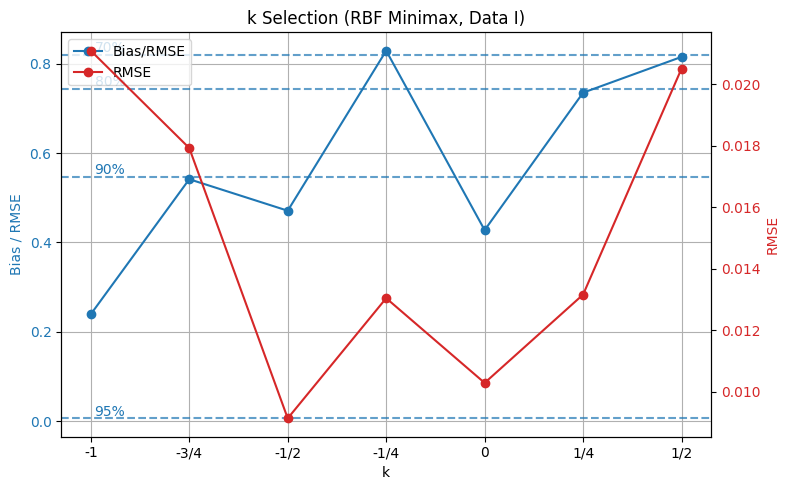

In [224]:
# plt.plot(np.log(Bsv), rmsev, marker='o', label='RMSE')
# plt.plot(np.log(Bsv), biasv/rmse, marker='o', label='Bias/RMSE')
# plt.title('k selection (RBF Minimax, Data I)')
# plt.xticks(np.log(Bsv))
# plt.grid()
# plt.legend()
# plt.show()


# plt.plot(np.log(Bsv), rmsev, marker='o', label='RMSE')
# plt.plot(np.log(Bsv), biasv/rmse, marker='o', label='Bias/RMSE')
# plt.title('k selection (Linear Minimax, Data I)')
# plt.xticks(np.log(Bsv), ['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2'])
# plt.grid()
# plt.xlabel('B')
# plt.legend()
# plt.show()
biasoverrmse = np.array(biasv)/np.array(rmsev)  

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Bias / RMSE
color1 = 'tab:blue'
line1, = ax1.plot(np.log(Bsv), biasoverrmse, marker='o', color=color1, label='Bias/RMSE')
ax1.set_xlabel('k')
ax1.set_ylabel('Bias / RMSE', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# X-axis ticks
ax1.set_xticks(np.log(Bsv))
ax1.set_xticklabels(['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2'])

# Add horizontal lines for coverage levels
for label, threshold in coverage_levels.items():
    ax1.axhline(y=threshold, color=color1, linestyle='--', alpha=0.7)
    ax1.text(np.log(Bsv[0]) + 0.05, threshold+0.015, label,
             va='center', ha='left', fontsize=10, color=color1)

# Secondary y-axis for RMSE
ax2 = ax1.twinx()
color2 = 'tab:red'
line2, = ax2.plot(np.log(Bsv), rmsev, marker='o', color=color2, label='RMSE')
ax2.set_ylabel('RMSE', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Title, grid, and layout
plt.title('k Selection (RBF Minimax, Data I)')
ax1.grid(True)
plt.tight_layout()
plt.show()

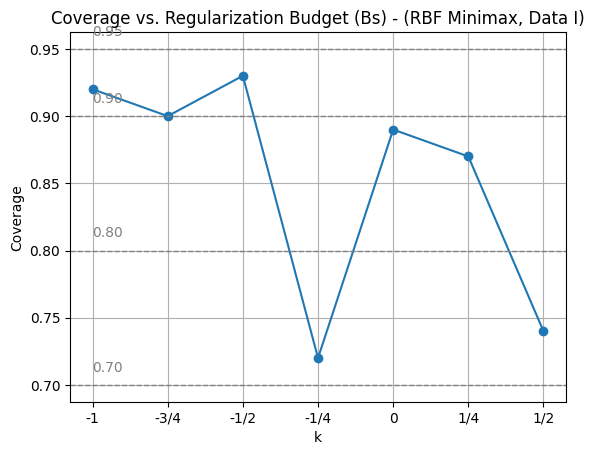

In [225]:
# coverage
plt.plot(np.log(Bsv), coveragev, marker='o', label='Coverage')
# Add horizontal reference lines at common confidence levels
for level in [0.7, 0.8, 0.9, 0.95]:
    plt.axhline(y=level, color='gray', linestyle='--', linewidth=1)
    plt.text(np.log(Bsv)[0], level + 0.01, f'{level:.2f}', color='gray')

# Customize the plot
plt.xlabel('k')
plt.ylabel('Coverage')
plt.title('Coverage vs. Regularization Budget (Bs) - (RBF Minimax, Data I)')
plt.grid(True)
plt.xticks(np.log(Bsv), ['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2'])
plt.show()

choose k = 0, Bs = p^0 = 1, 

# Data 2

In [226]:
def brightness_f(x):
  return np.array([np.mean(i) for i in x])

def inv_logit(x):
  return 1 / (1 + np.exp(-x))

def propensity_score(x):
  return inv_logit((1/15)*(x-123))

def assign_by_group(x, l):
  
    beta0 = -5
    beta1 = 1
    beta2 = 1
    beta3 = -1

    Xl_i = beta0 + beta1 * x + beta2 * (l == 'BACTERIA') + beta3 * (l == 'VIRUS')
    p_i = propensity_score(Xl_i)
    np.random.seed(0)
    w_i = np.random.binomial(1, p_i)

    gamma_0 = 0
    
    gammas = np.where(l == 'NORMAL', 0, np.where(l == 'BACTERIA', -1, -1))
    taus = np.where(l == 'NORMAL', 0, np.where(l == 'BACTERIA', 1, -1))

    y_0 = gamma_0 + gammas + p_i
    y_1 = gamma_0 + gammas + p_i + taus

    return p_i, w_i, y_1, y_0

L = df_combined['label']

P, W, Y1, Y0 = assign_by_group(X, L)
np.random.seed(0)
random_index = np.random.choice(range(5216), 200, replace=False)
X_0 = X[random_index]
P_0 = P[random_index]
W_0 = W[random_index]
Y1_0 = Y1[random_index]
Y0_0 = Y0[random_index]
L_0 = L[random_index] 

label_dummies = pd.get_dummies(L_0, drop_first=False)  
X_features = np.column_stack((X_0, label_dummies['BACTERIA'], label_dummies['VIRUS']))

In [227]:
set_seed(0)
def modeling():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

df_combined['Y'] = Y
df_combined['W'] = W
df_combined['P'] = P

X_full = np.array([np.array(x) for x in bright_matrix])
y_full = df_combined['Y'].values

N=5216
model_full = modeling()
model_full.fit(X_full, y_full, epochs=5, batch_size=16, validation_split=0.2, shuffle=True)
y_pred = model_full.predict(X_full)

/Users/wangzijian/Desktop/HONOR/python_honor/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 4.3858 - val_loss: 0.3137
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.3730 - val_loss: 0.3097
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.3700 - val_loss: 0.2923
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.3528 - val_loss: 0.2900
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.3360 - val_loss: 0.2750
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


In [228]:
true = 0.227
print('true:', true)

true: 0.227


## Minimax

In [229]:
X1 = X_features[:, 0]
L1 = X_features[:, 1]
L2 = X_features[:, 2]
psi = np.column_stack((
    np.ones(len(X1)),        # Intercept
    X1,                      # brightness
    L1,                      # BACTERIA
    L2,                      # VIRUS
    X1**2,                   # brightness^2
))

n = len(X_0)
A = np.zeros((6, n))
b = np.zeros(6)
psi_dim = psi.shape[1]  
A = np.zeros((2 * psi_dim, n)) 
b = np.zeros(2 * psi_dim)  

for i in range(n):
    A[:psi_dim, i] = psi[i] * (1 - W_0[i])
    A[psi_dim:, i] = psi[i] * W_0[i]
    b[:psi_dim] += -psi[i]
    b[psi_dim:] += psi[i]

A = A/n
b = b/n

lambda_reg = 1.7677669529663689e-06

AT_A = np.dot(A.T, A) + lambda_reg * np.eye(A.shape[1])
AT_b = np.dot(A.T, b)
gamma_mini = np.linalg.solve(AT_A, AT_b)
Y_0 = W_0 * Y1_0 + (1 - W_0) * Y0_0
ipw_mini = np.mean(gamma_mini * Y_0)
print(ipw_mini)

0.27364829495921245


In [230]:
lambda_reg = 1.25e-07

AT_A = np.dot(A.T, A) + lambda_reg * np.eye(A.shape[1])
AT_b = np.dot(A.T, b)
gamma_mini2 = np.linalg.solve(AT_A, AT_b)
Y_0 = W_0 * Y1_0 + (1 - W_0) * Y0_0
ipw_mini2 = np.mean(gamma_mini2 * Y_0)
print(ipw_mini2)

0.25438300572486894


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/372552340.py:10: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/372552340.py:11: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


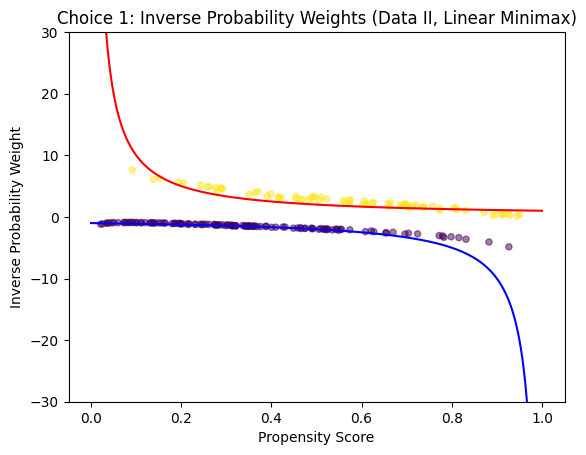

In [231]:
# x = np.array(range(0,220))
# plt.scatter(X_0, gamma_mini, c = W_0,alpha = .5, s = 10)
# plt.plot(x, 1/(propensity_score(x)), color = 'red')
# plt.plot(x, 1/((propensity_score(x)-1)), color = 'blue')
# plt.title('Inverse Probability Weights (Data II, Linear Minimax)')
# plt.ylim(-40,40)
# plt.show()

x_vals = np.linspace(1,0, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, gamma_mini, c = W_0,alpha = .5, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Choice 1: Inverse Probability Weights (Data II, Linear Minimax)')
plt.ylim(-30, 30)
plt.show()


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/2804032.py:2: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/2804032.py:3: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


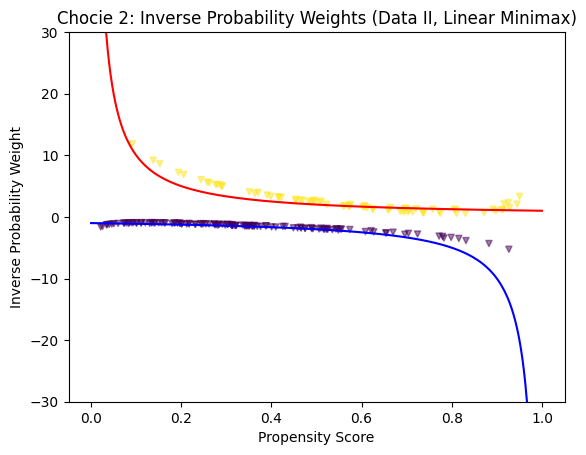

In [232]:
x_vals = np.linspace(1,0, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, gamma_mini2, c = W_0,alpha = .5, s = 20, marker='v')
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Chocie 2: Inverse Probability Weights (Data II, Linear Minimax)')
plt.ylim(-30, 30)
plt.show()

In [233]:
pes_mini = []
se_mini = []
coverage_flags = []

N = 5216
n = 200

for s in range(100):  # outer loop: sample subsets
    np.random.seed(s)
    i = np.random.choice(range(5216), 200, replace=False)

    # Subset data
    X_s = X[i]
    W_s = W[i]
    Y1_s = Y1[i]
    Y0_s = Y0[i]
    y_preds = y_pred[i].reshape(-1)
    Y_full_s = W_s * Y1_s + (1 - W_s) * Y0_s
    label_dummies = pd.get_dummies(L, drop_first=False)  # Create dummies for labels
    L1_s = label_dummies['BACTERIA'].values[i]
    L2_s = label_dummies['VIRUS'].values[i]

    # Build basis psi: [1, X, L1, L2, X^2]
    psi = np.column_stack((
        np.ones(len(X_s)),
        X_s,
        L1_s,
        L2_s,
        X_s**2
    ))
    psi_dim = psi.shape[1]

    # Build A and b
    A = np.zeros((2 * psi_dim, n))
    b = np.zeros(2 * psi_dim)
    for k in range(n):
        A[:psi_dim, k] = psi[k] * (1 - W_s[k])
        A[psi_dim:, k] = psi[k] * W_s[k]
        b[:psi_dim] += -psi[k]
        b[psi_dim:] += psi[k]
    A /= n
    b /= n

    # Solve minimax problem
    lambda_reg = 1.7677669529663689e-06
    AT_A = np.dot(A.T, A) + lambda_reg * np.eye(n)
    AT_b = np.dot(A.T, b)
    gamma_mini = np.linalg.solve(AT_A, AT_b)

    # Compute IPW estimate
    ipw_estimate = np.mean(gamma_mini * Y_full_s)
    pes_mini.append(ipw_estimate)

    # Variance estimate
    Y_full_s = W_s * Y1_s + (1 - W_s) * Y0_s
    v_sum = gamma_mini**2 * (Y_full_s - y_preds)**2
    v_hat = np.sum(v_sum) / N**2
    se_hat = np.sqrt(v_hat)
    se_mini.append(se_hat)

# Summarize results
pes_mini = np.array(pes_mini)
se_mini = np.array(se_mini)
exppes = np.mean(pes_mini)
samplestd = np.std(pes_mini)
expstd = np.mean(se_mini)

# Empirical 95% CI
true_arm_l, true_arm_r =  true - 1.96 * samplestd, true + 1.96 * samplestd
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes_mini]
coverage = np.mean(coverage_flags)

# Print results
print('coverage:', coverage)
print('sample std:', samplestd)
print('expected std:', expstd)
print('expected pes:', exppes)


coverage: 0.96
sample std: 0.062219561586772804
expected std: 0.008518349087485074
expected pes: 0.23073998705952403


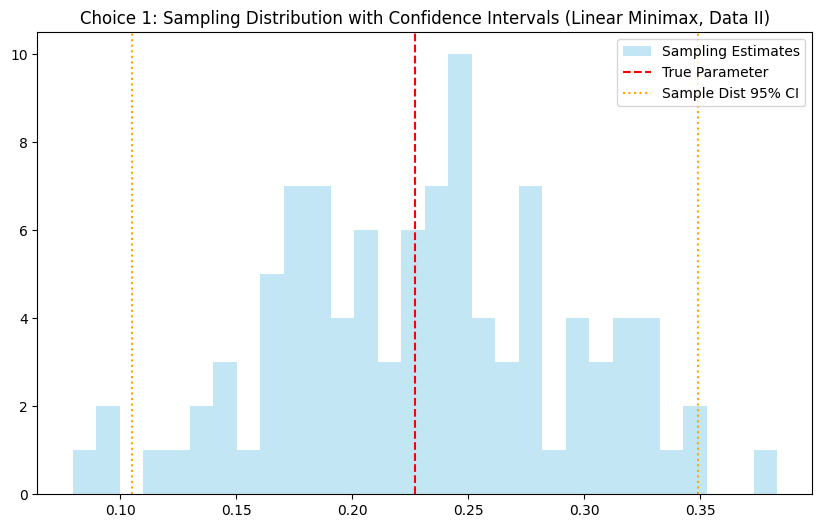

In [234]:
plt.figure(figsize=(10, 6))
plt.hist(pes_mini, bins=30, alpha=0.5, color='skyblue', label='Sampling Estimates')
plt.axvline(true, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(pes_mini, se_mini)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1, label=label)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 1: Sampling Distribution with Confidence Intervals (Linear Minimax, Data II)')

plt.legend()
plt.show()

In [235]:
pes_mini = []
se_mini = []
coverage_flags = []

N = 5216
n = 200

for s in range(100):  # outer loop: sample subsets
    np.random.seed(s)
    i = np.random.choice(range(5216), 200, replace=False)

    # Subset data
    X_s = X[i]
    W_s = W[i]
    Y1_s = Y1[i]
    Y0_s = Y0[i]
    y_preds = y_pred[i].reshape(-1)
    Y_full_s = W_s * Y1_s + (1 - W_s) * Y0_s
    label_dummies = pd.get_dummies(L, drop_first=False)  # Create dummies for labels
    L1_s = label_dummies['BACTERIA'].values[i]
    L2_s = label_dummies['VIRUS'].values[i]

    # Build basis psi: [1, X, L1, L2, X^2]
    psi = np.column_stack((
        np.ones(len(X_s)),
        X_s,
        L1_s,
        L2_s,
        X_s**2
    ))
    psi_dim = psi.shape[1]

    # Build A and b
    A = np.zeros((2 * psi_dim, n))
    b = np.zeros(2 * psi_dim)
    for k in range(n):
        A[:psi_dim, k] = psi[k] * (1 - W_s[k])
        A[psi_dim:, k] = psi[k] * W_s[k]
        b[:psi_dim] += -psi[k]
        b[psi_dim:] += psi[k]
    A /= n
    b /= n

    # Solve minimax problem
    lambda_reg = 1.25e-07
    AT_A = np.dot(A.T, A) + lambda_reg * np.eye(n)
    AT_b = np.dot(A.T, b)
    gamma_mini = np.linalg.solve(AT_A, AT_b)

    # Compute IPW estimate
    ipw_estimate = np.mean(gamma_mini * Y_full_s)
    pes_mini.append(ipw_estimate)

    # Variance estimate
    Y_full_s = W_s * Y1_s + (1 - W_s) * Y0_s
    v_sum = gamma_mini**2 * (Y_full_s - y_preds)**2
    v_hat = np.sum(v_sum) / N**2
    se_hat = np.sqrt(v_hat)
    se_mini.append(se_hat)

# Summarize results
pes_mini = np.array(pes_mini)
se_mini = np.array(se_mini)
exppes = np.mean(pes_mini)
samplestd = np.std(pes_mini)
expstd = np.mean(se_mini)

# Empirical 95% CI
true_arm_l, true_arm_r =  true - 1.96 * samplestd, true + 1.96 * samplestd
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes_mini]
coverage = np.mean(coverage_flags)

# Print results
print('coverage:', coverage)
print('sample std:', samplestd)
print('expected std:', expstd)
print('expected pes:', exppes)


coverage: 0.95
sample std: 0.06307871416574892
expected std: 0.008988215167673735
expected pes: 0.21474576252692792


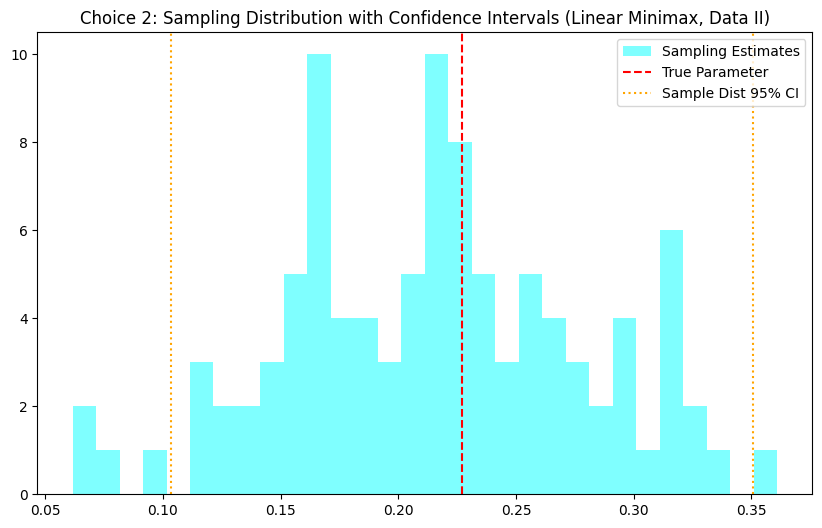

In [236]:
plt.figure(figsize=(10, 6))
plt.hist(pes_mini, bins=30, alpha=0.5, color='cyan', label='Sampling Estimates')
plt.axvline(true, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(pes_mini, se_mini)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1, label=label)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 2: Sampling Distribution with Confidence Intervals (Linear Minimax, Data II)')

plt.legend()
plt.show()

In [237]:
rmsev = []
biasv = []
p_mini = 200
sigma = 1
Bsv = []
coveragev = []

for p in [-1, -3/4, -1/2, -1/4, 0, 1/4, 1/2]:
    Bs = p_mini**p
    Bsv.append(Bs)
    pes_mini = []
    se_mini = []
    coverage_flags = []
    lamb = sigma**2/(Bs**2*200**2)

    for s in range(100):  # outer loop: sample subsets
        np.random.seed(s)
        i = np.random.choice(range(5216), 200, replace=False)

        # Sampled data
        X_s = X[i]
        W_s = W[i]
        Y1_s = Y1[i]
        Y0_s = Y0[i]
        Y_full_s = W_s * Y1_s + (1 - W_s) * Y0_s
        y_preds = y_pred[i].reshape(-1)
        L1_s = label_dummies['BACTERIA'].values[i]
        L2_s = label_dummies['VIRUS'].values[i]

        # Construct psi = [1, X, L1, L2, X^2]
        psi = np.column_stack((
            np.ones(len(X_s)),
            X_s,
            L1_s,
            L2_s,
            X_s ** 2
        ))
        psi_dim = psi.shape[1]

        # Build A and b
        n = len(X_s)
        A = np.zeros((2 * psi_dim, n))
        b = np.zeros(2 * psi_dim)

        for k in range(n):
            A[:psi_dim, k] = psi[k] * (1 - W_s[k])
            A[psi_dim:, k] = psi[k] * W_s[k]
            b[:psi_dim] += -psi[k]
            b[psi_dim:] += psi[k]

        A /= n
        b /= n

        # Solve minimax gamma
        lambda_reg = lamb
        AT_A = np.dot(A.T, A) + lambda_reg * np.eye(n)
        AT_b = np.dot(A.T, b)
        gamma_mini = np.linalg.solve(AT_A, AT_b)

        # IPW estimate
        ipw_estimate = np.mean(gamma_mini * Y_full_s)
        pes_mini.append(ipw_estimate)

        # Variance estimate
        v_sum = gamma_mini**2 * (Y_full_s - y_preds)**2
        v_hat = np.sum(v_sum) / N**2
        se_hat = np.sqrt(v_hat)
        se_mini.append(se_hat)

    # Summarize across 50 reps
    pes_mini = np.array(pes_mini)
    se_mini = np.array(se_mini)
    exppes = np.mean(pes_mini)
    samplestd = np.std(pes_mini)
    expstd = np.mean(se_mini)

    # Empirical CI for true ATE = 1
    true_arm_l, true_arm_r = true - 1.96 * samplestd, true + 1.96 * samplestd
    coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes_mini]
    coverage = np.mean(coverage_flags)
    rmse = np.sqrt(np.mean((pes_mini - true)**2))
    bias = np.abs(np.mean(pes_mini - true))


    # Log results
    print(f'k: {p}')
    print(f'lambda: {lamb}')
    print(f'Bs: {Bs:.5f}')
    print(f'coverage: {coverage:.3f}')
    print(f'sample std: {samplestd:.4f}')
    print(f'expected pes: {exppes:.4f}')
    print(f'bias: {bias:.4f}')
    print(f'bias/rmse: {bias/rmse:.4f}')

    print('---')

    rmsev.append(rmse)
    biasv.append(bias)
    coveragev.append(coverage)




k: -1
lambda: 1.0
Bs: 0.00500
coverage: 0.740
sample std: 0.0990
expected pes: 0.3524
bias: 0.1254
bias/rmse: 0.7848
---
k: -0.75
lambda: 0.07071067811865477
Bs: 0.01880
coverage: 0.940
sample std: 0.1109
expected pes: 0.2802
bias: 0.0532
bias/rmse: 0.4325
---
k: -0.5
lambda: 0.005
Bs: 0.07071
coverage: 0.950
sample std: 0.1100
expected pes: 0.2669
bias: 0.0399
bias/rmse: 0.3411
---
k: -0.25
lambda: 0.0003535533905932737
Bs: 0.26591
coverage: 0.930
sample std: 0.0837
expected pes: 0.2631
bias: 0.0361
bias/rmse: 0.3959
---
k: 0
lambda: 2.5e-05
Bs: 1.00000
coverage: 0.930
sample std: 0.0633
expected pes: 0.2451
bias: 0.0181
bias/rmse: 0.2745
---
k: 0.25
lambda: 1.7677669529663689e-06
Bs: 3.76060
coverage: 0.960
sample std: 0.0622
expected pes: 0.2307
bias: 0.0037
bias/rmse: 0.0600
---
k: 0.5
lambda: 1.25e-07
Bs: 14.14214
coverage: 0.950
sample std: 0.0631
expected pes: 0.2147
bias: 0.0123
bias/rmse: 0.1907
---


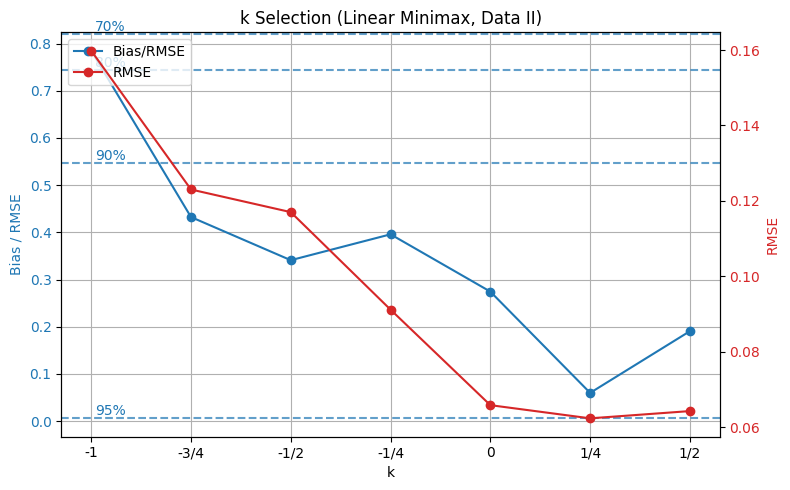

In [238]:
# plt.plot(np.log(Bsv), rmsev, marker='o', label='RMSE')
# plt.plot(np.log(Bsv), biasv/rmse, marker='o', label='Bias/RMSE')
# plt.title('k selection (Linear Minimax, Data II)')
# plt.xticks(np.log(Bsv))
# plt.grid()
# plt.legend()
# plt.show()


biasoverrmse = np.array(biasv)/np.array(rmsev)  

# plt.plot(np.log(Bsv), rmsev, marker='o', label='RMSE')
# plt.plot(np.log(Bsv), biasv/rmse, marker='o', label='Bias/RMSE')
# plt.title('k selection (Linear Minimax, Data I)')
# plt.xticks(np.log(Bsv), ['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2'])
# plt.grid()
# plt.xlabel('B')
# plt.legend()
# plt.show()

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Bias / RMSE
color1 = 'tab:blue'
line1, = ax1.plot(np.log(Bsv), biasoverrmse, marker='o', color=color1, label='Bias/RMSE')
ax1.set_xlabel('k')
ax1.set_ylabel('Bias / RMSE', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# X-axis ticks
ax1.set_xticks(np.log(Bsv))
ax1.set_xticklabels(['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2'])

# Add horizontal lines for coverage levels
for label, threshold in coverage_levels.items():
    ax1.axhline(y=threshold, color=color1, linestyle='--', alpha=0.7)
    ax1.text(np.log(Bsv[0]) + 0.05, threshold+0.015, label,
             va='center', ha='left', fontsize=10, color=color1)

# Secondary y-axis for RMSE
ax2 = ax1.twinx()
color2 = 'tab:red'
line2, = ax2.plot(np.log(Bsv), rmsev, marker='o', color=color2, label='RMSE')
ax2.set_ylabel('RMSE', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Title, grid, and layout
plt.title('k Selection (Linear Minimax, Data II)')
ax1.grid(True)
plt.tight_layout()
plt.show()

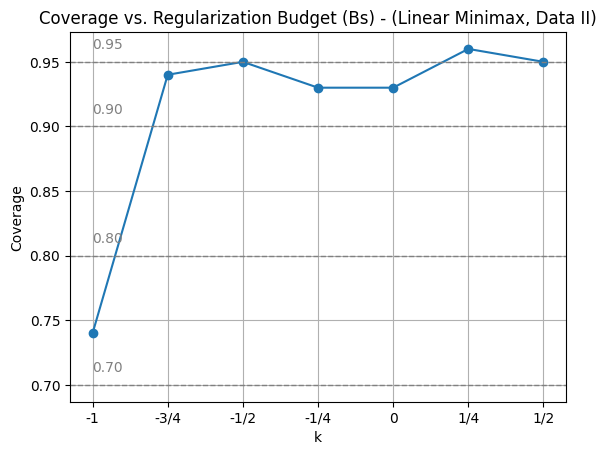

In [239]:
plt.plot(np.log(Bsv), coveragev, marker='o', label='Coverage')

# Add horizontal reference lines at common confidence levels
for level in [0.7, 0.8, 0.9, 0.95]:
    plt.axhline(y=level, color='gray', linestyle='--', linewidth=1)
    plt.text(np.log(Bsv)[0], level + 0.01, f'{level:.2f}', color='gray')

# Customize the plot
plt.xlabel('k')
plt.ylabel('Coverage')
plt.title('Coverage vs. Regularization Budget (Bs) - (Linear Minimax, Data II)')
plt.grid(True)
plt.xticks(np.log(Bsv), ['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2'])
plt.show()


choose k = -1/4, lambda = 1.4179993795490565e-06

## RBF

In [240]:
from scipy.spatial.distance import cdist
c = 1
d = 2
s = np.mean(X)
sw= 10
sigma = 0.25

label_dummies = pd.get_dummies(L_0, drop_first=False)  
X_features = np.column_stack((X_0, label_dummies['BACTERIA'], label_dummies['VIRUS']))

WX = np.concatenate([W_0.reshape(-1,1)*sw, X_features/s], axis = 1)
WX_0 = np.concatenate([np.zeros_like(W_0).reshape(-1,1)*sw,X_features/s], axis = 1)
WX_1 = np.concatenate([np.ones_like(W_0).reshape(-1,1)*sw,X_features/s], axis = 1)

K_XX = np.exp(-cdist(WX, WX, 'sqeuclidean')/ (2 * sigma**2))
K_X1 = np.exp(-cdist(WX, WX_1, 'sqeuclidean')/ (2 * sigma**2))@ np.ones((n, 1))
K_X0 = np.exp(-cdist(WX, WX_0, 'sqeuclidean')/ (2 * sigma**2))@ np.ones((n, 1))
K_Xdiff = K_X1 - K_X0
lambda1 = 0.0003535533905932737
I = np.eye(K_XX.shape[0])
#gamma_optimal = (np.linalg.solve((1/n**2)*K_XX + (1/n**2)*sigma_squared * I, (2/n**2)*(K_Xdiff))).flatten()
gamma_rbf = (np.linalg.solve(K_XX + lambda1 * I, (K_Xdiff))).flatten()
Y_full = W_0 * Y1_0 + (1 - W_0) * Y0_0
ipw_rbf = np.mean(gamma_rbf * Y_full)
print("IPW estimate:", ipw_rbf)

IPW estimate: 0.29236392654054777


In [241]:
lambda1 = 1.7677669529663689e-06
I = np.eye(K_XX.shape[0])
#gamma_optimal = (np.linalg.solve((1/n**2)*K_XX + (1/n**2)*sigma_squared * I, (2/n**2)*(K_Xdiff))).flatten()
gamma_rbf2 = (np.linalg.solve(K_XX + lambda1 * I, (K_Xdiff))).flatten()
Y_full = W_0 * Y1_0 + (1 - W_0) * Y0_0
ipw_rbf2 = np.mean(gamma_rbf2 * Y_full)
print("IPW estimate:", ipw_rbf2)

IPW estimate: 0.2777919119893001


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/1322138014.py:10: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/1322138014.py:11: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


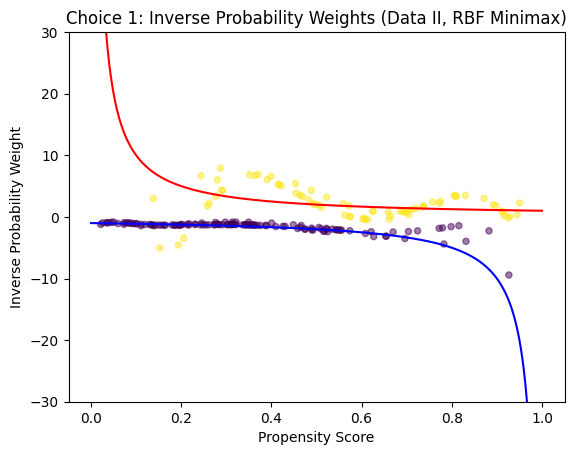

In [242]:
# x = np.array(range(0,220))
# plt.scatter(X_0, gamma_rbf, c = W_0,alpha = .5, s = 10)
# plt.plot(x, 1/(propensity_score(x)), color = 'red')
# plt.plot(x, 1/((propensity_score(x)-1)), color = 'blue')
# plt.title('Inverse Probability Weights (Data II, RBF Minimax)')
# plt.ylim(-40,40)
# plt.show()

x_vals = np.linspace(1,0, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, gamma_rbf, c = W_0,alpha = .5, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Choice 1: Inverse Probability Weights (Data II, RBF Minimax)')
plt.ylim(-30, 30)
plt.show()

/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/2651068094.py:2: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/2651068094.py:3: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


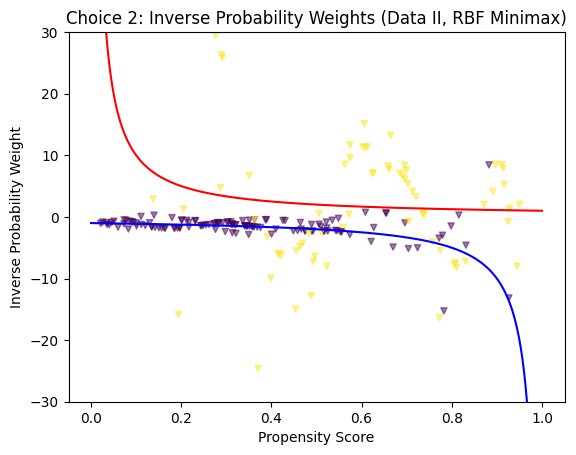

In [243]:
x_vals = np.linspace(1,0, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, gamma_rbf2, c = W_0,alpha = .5, s = 20, marker='v')
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Choice 2: Inverse Probability Weights (Data II, RBF Minimax)')
plt.ylim(-30, 30)
plt.show()

In [244]:
pes_rbf = []
se_rbf = []
coverage_flags = []
N = 5216
n = 200
sigma2 = 0.25
lambda_reg = 0.0003535533905932737
label_dummies = pd.get_dummies(L, drop_first=False)
X_features = np.column_stack((X, label_dummies['BACTERIA'], label_dummies['VIRUS']))
for s in range(100):  # outer loop: sample subsets
    np.random.seed(s)
    i = np.random.choice(range(N), n, replace=False)
    X_0s = np.array(X_features[i])
    W_0s = np.array(W[i])
    Y1_0s = np.array(Y1[i])
    Y0_0s = np.array(Y0[i])
    y_preds = np.array(y_pred[i]).reshape(-1)

    # RBF kernel matrix and target vector
    sw = 10
    s_avg = np.mean(X)
    
    WX = np.concatenate([W_0s.reshape(-1,1)*sw, X_0s/s_avg], axis = 1)
    WX_0 = np.concatenate([np.zeros_like(W_0s).reshape(-1,1)*sw,X_0s/s_avg], axis = 1)
    WX_1 = np.concatenate([np.ones_like(W_0s).reshape(-1,1)*sw,X_0s/s_avg], axis = 1)

    K_XX = np.exp(-cdist(WX, WX, 'sqeuclidean')/ (2 * sigma**2))
    K_X1 = np.exp(-cdist(WX, WX_1, 'sqeuclidean')/ (2 * sigma**2))@ np.ones((n, 1))
    K_X0 = np.exp(-cdist(WX, WX_0, 'sqeuclidean')/ (2 * sigma**2))@ np.ones((n, 1))
    K_Xdiff = K_X1 - K_X0
    I = np.eye(n)

    # solve for gamma using ridge regularization
    gamma_rbf = np.linalg.solve(K_XX + lambda_reg * I, K_Xdiff).flatten()

    # IPW estimate
    Y_fulls = W_0s * Y1_0s + (1 - W_0s) * Y0_0s
    ipw_estimate = np.mean(gamma_rbf * Y_fulls)
    pes_rbf.append(ipw_estimate)

    # Variance estimate
    v_sum = gamma_rbf**2 * (Y_fulls - y_preds) ** 2
    v_hat = (1 / N**2) * np.sum(v_sum)
    se_hat = np.sqrt(v_hat)
    se_rbf.append(se_hat)

# Summarize sampling distribution
pes_rbf = np.array(pes_rbf)
se_rbf = np.array(se_rbf)
exppes = np.mean(pes_rbf)
samplestd = np.std(pes_rbf)
true_arm_l, true_arm_r = true - 1.96 * samplestd, true + 1.96 * samplestd
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes_rbf]
coverage = np.mean(coverage_flags)
expstd = np.mean(se_rbf)

print('coverage:', coverage)
print('sample std:', samplestd)
print('expected std:', expstd)
print('expected pes:', exppes)

coverage: 0.94
sample std: 0.07437195623253708
expected std: 0.013194165755996497
expected pes: 0.23759239524416256


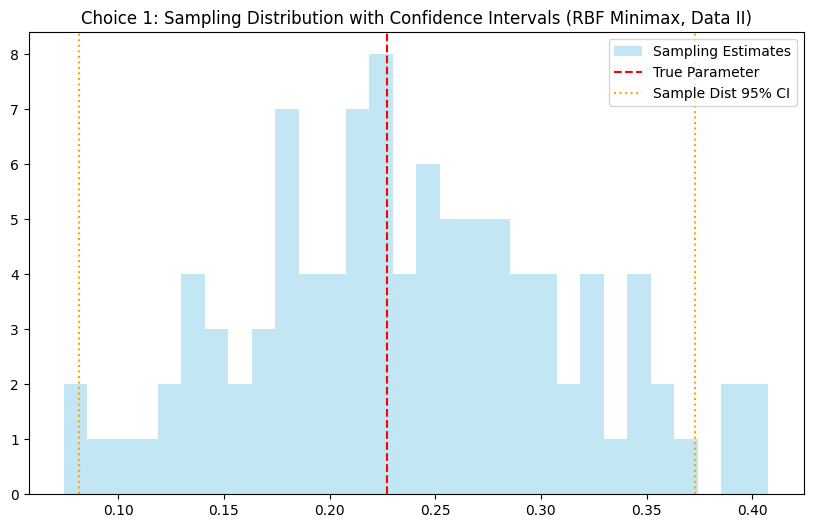

In [245]:
plt.figure(figsize=(10, 6))
plt.hist(pes_rbf, bins=30, alpha=0.5, color='skyblue', label='Sampling Estimates')
plt.axvline(true, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(pes_rbf, se_rbf)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1, label=label)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 1: Sampling Distribution with Confidence Intervals (RBF Minimax, Data II)')

plt.legend()
plt.show()


In [246]:


pes_rbf = []
se_rbf = []
coverage_flags = []
N = 5216
n = 200
sigma2 = 0.25
lambda_reg = 1.7677669529663689e-06
label_dummies = pd.get_dummies(L, drop_first=False)
X_features = np.column_stack((X, label_dummies['BACTERIA'], label_dummies['VIRUS']))
for s in range(100):  # outer loop: sample subsets
    np.random.seed(s)
    i = np.random.choice(range(N), n, replace=False)
    X_0s = np.array(X_features[i])
    W_0s = np.array(W[i])
    Y1_0s = np.array(Y1[i])
    Y0_0s = np.array(Y0[i])
    y_preds = np.array(y_pred[i]).reshape(-1)

    # RBF kernel matrix and target vector
    sw = 10
    s_avg = np.mean(X)
    
    WX = np.concatenate([W_0s.reshape(-1,1)*sw, X_0s/s_avg], axis = 1)
    WX_0 = np.concatenate([np.zeros_like(W_0s).reshape(-1,1)*sw,X_0s/s_avg], axis = 1)
    WX_1 = np.concatenate([np.ones_like(W_0s).reshape(-1,1)*sw,X_0s/s_avg], axis = 1)

    K_XX = np.exp(-cdist(WX, WX, 'sqeuclidean')/ (2 * sigma**2))
    K_X1 = np.exp(-cdist(WX, WX_1, 'sqeuclidean')/ (2 * sigma**2))@ np.ones((n, 1))
    K_X0 = np.exp(-cdist(WX, WX_0, 'sqeuclidean')/ (2 * sigma**2))@ np.ones((n, 1))
    K_Xdiff = K_X1 - K_X0
    I = np.eye(n)

    # solve for gamma using ridge regularization
    gamma_rbf = np.linalg.solve(K_XX + lambda_reg * I, K_Xdiff).flatten()

    # IPW estimate
    Y_fulls = W_0s * Y1_0s + (1 - W_0s) * Y0_0s
    ipw_estimate = np.mean(gamma_rbf * Y_fulls)
    pes_rbf.append(ipw_estimate)

    # Variance estimate
    v_sum = gamma_rbf**2 * (Y_fulls - y_preds) ** 2
    v_hat = (1 / N**2) * np.sum(v_sum)
    se_hat = np.sqrt(v_hat)
    se_rbf.append(se_hat)

# Summarize sampling distribution
pes_rbf = np.array(pes_rbf)
se_rbf = np.array(se_rbf)
exppes = np.mean(pes_rbf)
samplestd = np.std(pes_rbf)
true_arm_l, true_arm_r = true - 1.96 * samplestd, true + 1.96 * samplestd
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes_rbf]
coverage = np.mean(coverage_flags)
expstd = np.mean(se_rbf)

print('coverage:', coverage)
print('sample std:', samplestd)
print('expected std:', expstd)
print('expected pes:', exppes)

coverage: 0.94
sample std: 0.06239629445822218
expected std: 0.051530718453433544
expected pes: 0.2332228983638747


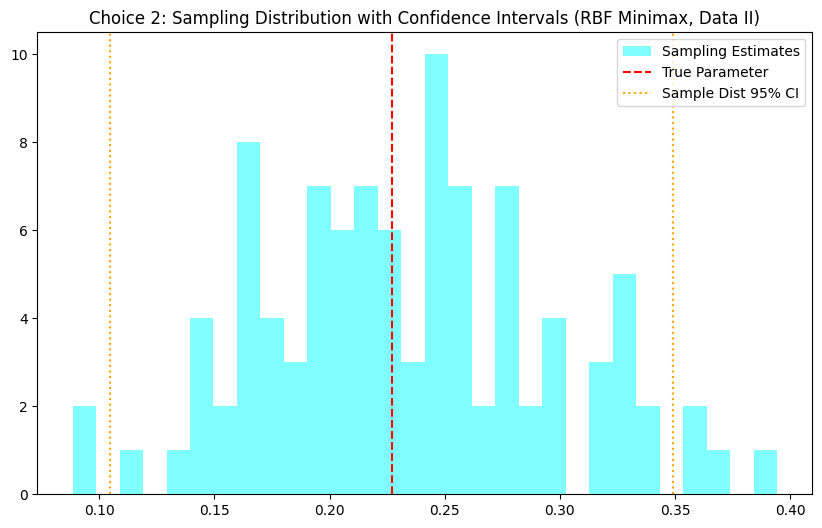

In [247]:
plt.figure(figsize=(10, 6))
plt.hist(pes_rbf, bins=30, alpha=0.5, color='cyan', label='Sampling Estimates')
plt.axvline(true, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(pes_rbf, se_rbf)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1, label=label)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 2: Sampling Distribution with Confidence Intervals (RBF Minimax, Data II)')

plt.legend()
plt.show()


In [248]:
label_dummies = pd.get_dummies(L, drop_first=False)
X_features = np.column_stack((X, label_dummies['BACTERIA'], label_dummies['VIRUS']))

N = 5216
n = 200
sigma2 = 0.25
sw = 10
s_avg = np.mean(X)

rmsev = []
biasv = []
p_mini = 200
sigma = 1
Bsv = []
coveragev = []


for p in [-1, -3/4, -1/2, -1/4, 0, 1/4, 1/2]:
    Bs = p_mini**p
    Bsv.append(Bs)
    lambda_reg = sigma**2/(Bs**2*200**2)
    pes_rbf = []
    se_rbf = []
    coverage_flags = []

    for s in range(100):  # outer loop: sample subsets
        np.random.seed(s)
        i = np.random.choice(range(N), n, replace=False)
        X_0s = np.array(X_features[i])
        W_0s = np.array(W[i])
        Y1_0s = np.array(Y1[i])
        Y0_0s = np.array(Y0[i])
        y_preds = np.array(y_pred[i]).reshape(-1)

        # RBF kernel matrix and target vector
        WX = np.concatenate([W_0s.reshape(-1, 1) * sw, X_0s / s_avg], axis=1)
        WX_0 = np.concatenate([np.zeros_like(W_0s).reshape(-1, 1) * sw, X_0s / s_avg], axis=1)
        WX_1 = np.concatenate([np.ones_like(W_0s).reshape(-1, 1) * sw, X_0s / s_avg], axis=1)

        K_XX = np.exp(-cdist(WX, WX, 'sqeuclidean') / (2 * sigma2))
        K_X1 = np.exp(-cdist(WX, WX_1, 'sqeuclidean') / (2 * sigma2)) @ np.ones((n, 1))
        K_X0 = np.exp(-cdist(WX, WX_0, 'sqeuclidean') / (2 * sigma2)) @ np.ones((n, 1))
        K_Xdiff = K_X1 - K_X0
        I = np.eye(n)

        # solve for gamma using ridge regularization
        gamma_rbf = np.linalg.solve(K_XX + lambda_reg * I, K_Xdiff).flatten()

        # IPW estimate
        Y_fulls = W_0s * Y1_0s + (1 - W_0s) * Y0_0s
        ipw_estimate = np.mean(gamma_rbf * Y_fulls)
        pes_rbf.append(ipw_estimate)

        # Variance estimate
        v_sum = gamma_rbf**2 * (Y_fulls - y_preds) ** 2
        v_hat = (1 / N**2) * np.sum(v_sum)
        se_hat = np.sqrt(v_hat)
        se_rbf.append(se_hat)

    # Summarize sampling distribution
    pes_rbf = np.array(pes_rbf)
    se_rbf = np.array(se_rbf)
    exppes = np.mean(pes_rbf)
    samplestd = np.std(pes_rbf)
    true_arm_l, true_arm_r = true - 1.96 * samplestd, true + 1.96 * samplestd
    coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes_rbf]
    coverage = np.mean(coverage_flags)
    expstd = np.mean(se_rbf)
    rmse = np.sqrt(np.mean((pes_rbf - true)**2))
    bias = np.abs(np.mean(pes_rbf - true))

    print('p: ',p)
    print('lambda: ',lambda_reg)
    print('coverage:', coverage)
    print('sample std:', samplestd)
    print('expected std:', expstd)
    print('expected pes:', exppes)

    print('bias:', bias)
    print('bias/rmse:', bias/rmse)
    print('Bs:', Bs)
    print('---')

    rmsev.append(rmse)
    biasv.append(bias)
    coveragev.append(coverage)


p:  -1
lambda:  1.0
coverage: 0.92
sample std: 0.10692584705191033
expected std: 0.007459776700673273
expected pes: 0.29567738812763095
bias: 0.06867738812763094
bias/rmse: 0.5404198170826879
Bs: 0.005
---
p:  -0.75
lambda:  0.07071067811865477
coverage: 0.93
sample std: 0.11358253140300567
expected std: 0.008273168677035193
expected pes: 0.2818400991626646
bias: 0.05484009916266461
bias/rmse: 0.43479505806908486
Bs: 0.018803015465431967
---
p:  -0.5
lambda:  0.005
coverage: 0.95
sample std: 0.09585830649552125
expected std: 0.009078845102150287
expected pes: 0.25522677728346427
bias: 0.028226777283464264
bias/rmse: 0.2824717079783096
Bs: 0.07071067811865475
---
p:  -0.25
lambda:  0.0003535533905932737
coverage: 0.94
sample std: 0.06571028022405849
expected std: 0.01012354607898287
expected pes: 0.2365068250337431
bias: 0.009506825033743114
bias/rmse: 0.14318708203094926
Bs: 0.26591479484724945
---
p:  0
lambda:  2.5e-05
coverage: 0.94
sample std: 0.062475984813118494
expected std: 0.0

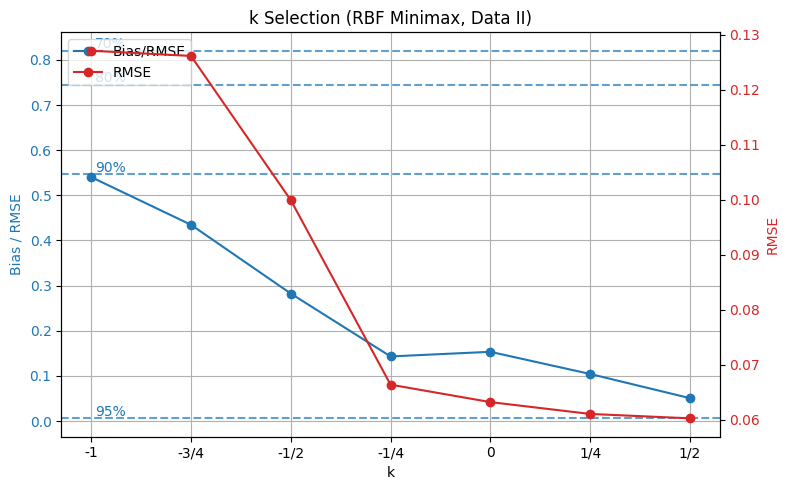

In [249]:
# plt.plot(np.log(Bsv), rmsev, marker='o', label='RMSE')
# plt.plot(np.log(Bsv), biasv/rmse, marker='o', label='Bias/RMSE')
# plt.title('k selection (RBF Minimax, Data II)')
# plt.xticks(np.log(Bsv))
# plt.grid()
# plt.legend()
# plt.show()

# plt.plot(np.log(Bsv), rmsev, marker='o', label='RMSE')
# plt.plot(np.log(Bsv), biasv/rmse, marker='o', label='Bias/RMSE')
# plt.title('k selection (Linear Minimax, Data II)')
# plt.xticks(np.log(Bsv))
# plt.grid()
# plt.legend()
# plt.show()


biasoverrmse = np.array(biasv)/np.array(rmsev)  

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Bias / RMSE
color1 = 'tab:blue'
line1, = ax1.plot(np.log(Bsv), biasoverrmse, marker='o', color=color1, label='Bias/RMSE')
ax1.set_xlabel('k')
ax1.set_ylabel('Bias / RMSE', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# X-axis ticks
ax1.set_xticks(np.log(Bsv))
ax1.set_xticklabels(['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2'])

# Add horizontal lines for coverage levels
for label, threshold in coverage_levels.items():
    ax1.axhline(y=threshold, color=color1, linestyle='--', alpha=0.7)
    ax1.text(np.log(Bsv[0]) + 0.05, threshold+0.015, label,
             va='center', ha='left', fontsize=10, color=color1)

# Secondary y-axis for RMSE
ax2 = ax1.twinx()
color2 = 'tab:red'
line2, = ax2.plot(np.log(Bsv), rmsev, marker='o', color=color2, label='RMSE')
ax2.set_ylabel('RMSE', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Title, grid, and layout
plt.title('k Selection (RBF Minimax, Data II)')
ax1.grid(True)
plt.tight_layout()
plt.show()

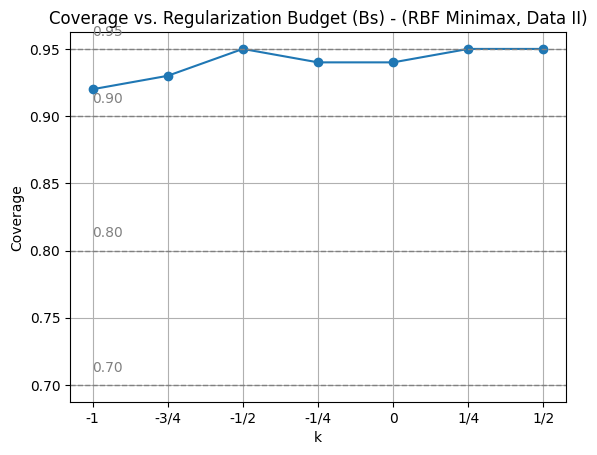

In [250]:
# coverage
plt.plot(np.log(Bsv), coveragev, marker='o', label='Coverage')
# Add horizontal reference lines at common confidence levels
for level in [0.7, 0.8, 0.9, 0.95]:
    plt.axhline(y=level, color='gray', linestyle='--', linewidth=1)
    plt.text(np.log(Bsv)[0], level + 0.01, f'{level:.2f}', color='gray')
# Customize the plot
plt.xlabel('k')
plt.ylabel('Coverage')
plt.title('Coverage vs. Regularization Budget (Bs) - (RBF Minimax, Data II)')
plt.grid(True)
plt.xticks(np.log(Bsv), ['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2'])
plt.show()

# Data 3


In [251]:

from scipy.signal import convolve2d
filter = np.array([[-1, -1, -1], 
                   [-1,  8, -1], 
                   [-1, -1, -1]])

n = 5216
H, W = 224, 224
filtered_features = np.zeros((n, H, W))

def filter_image(image):
    return convolve2d(image, filter, mode='same', boundary='fill', fillvalue=0)

for i in tqdm(range(n)):
    img = df_combined['image_array'][i]  # assume shape (224, 224)
    filtered_img = filter_image(img)
    filtered_features[i] = filtered_img**2  # store squared filtered image

print(filtered_features.shape)

def brightness_f(x):
  return np.array([np.mean(i) for i in x])


X_filter = brightness_f(filtered_features)
mu = np.mean(X_filter)
print(X_filter.shape)

def inv_logit(x):
  return 1 / (1 + np.exp(-x))

def propensity_score(x):
  return inv_logit((1/500)*(x-mu)) 

def assign(x, y_1 = 1, y_0 = 0):
  p = propensity_score(x)
  # seeding
  np.random.seed(0)
  w = np.random.binomial(1, p)
  y1 = y_1 + p
  y0 = y_0 + p
  return p, w, y1, y0



P, W, Y1, Y0 = assign(X_filter)
np.random.seed(0)
random_index = np.random.choice(range(5216), 200, replace=False)
X_0 = X_filter[random_index]
P_0 = P[random_index]
W_0 = W[random_index]
Y1_0 = Y1[random_index]
Y0_0 = Y0[random_index]

100%|██████████| 5216/5216 [00:07<00:00, 682.94it/s]


(5216, 224, 224)
(5216,)


In [252]:
set_seed(0)
def modeling():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

df_combined['Y'] = Y
df_combined['W'] = W
df_combined['P'] = P

X_full = filtered_features
y_full = df_combined['Y'].values

N=5216
model_full = modeling()
model_full.fit(X_full, y_full, epochs=5, batch_size=16, validation_split=0.2, shuffle=True)
y_pred = model_full.predict(X_full)

/Users/wangzijian/Desktop/HONOR/python_honor/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 24s 82ms/step - loss: 0.6319 - val_loss: 0.3499
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - loss: 0.3553 - val_loss: 0.3014
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - loss: 0.3160 - val_loss: 0.2853
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - loss: 0.3013 - val_loss: 0.2654
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - loss: 0.2959 - val_loss: 0.2598
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step


## Minimax


In [253]:
psi = np.zeros((len(X_0), 3))
psi[:, 0]=1
psi[:, 1]=X_0
psi[:, 2]=X_0**2

n = len(X_0)
A = np.zeros((6, n))
b = np.zeros(6)

for i in range(n):
    A[:3, i] = psi[i] * (1 - W_0[i])
    A[3:, i] = psi[i] * W_0[i]
    b[:3] += -psi[i]
    b[3:] += psi[i]

A = A/n
b = b/n

lambda_reg = 2.5e-05

AT_A = np.dot(A.T, A) + lambda_reg * np.eye(A.shape[1])
AT_b = np.dot(A.T, b)
gamma_mini = np.linalg.solve(AT_A, AT_b)
Y_0 = W_0 * Y1_0 + (1 - W_0) * Y0_0
ipw_mini = np.mean(gamma_mini * Y_0)
print(ipw_mini)

0.951149680494168


In [254]:

lambda_reg = 7.310044345532168e-07

AT_A = np.dot(A.T, A) + lambda_reg * np.eye(A.shape[1])
AT_b = np.dot(A.T, b)
gamma_mini2 = np.linalg.solve(AT_A, AT_b)
Y_0 = W_0 * Y1_0 + (1 - W_0) * Y0_0
ipw_mini2 = np.mean(gamma_mini2 * Y_0)
print(ipw_mini2)

1.109600043564352


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/1699373004.py:2: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/1699373004.py:3: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


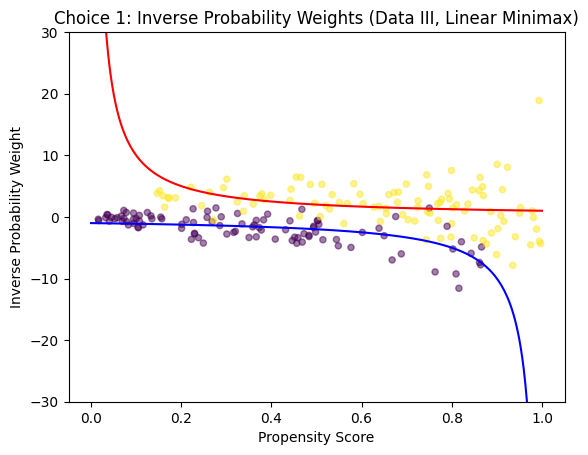

In [255]:
x_vals = np.linspace(1,0, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, gamma_mini, c = W_0,alpha = .5, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Choice 1: Inverse Probability Weights (Data III, Linear Minimax)')
plt.ylim(-30, 30)
plt.show()

/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/625643706.py:10: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/625643706.py:11: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


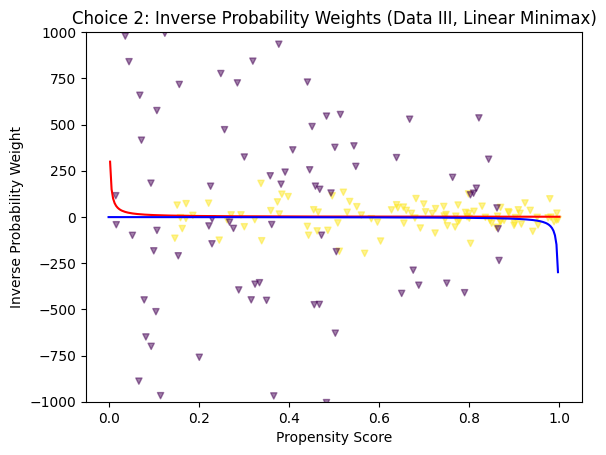

In [256]:
# x = np.array(range(0,7000))
# plt.scatter(X_0, gamma_mini, c = W_0,alpha = .5, s = 10)
# plt.plot(x, 1/(propensity_score(x)), color = 'red')
# plt.plot(x, 1/((propensity_score(x)-1)), color = 'blue')
# plt.title('Inverse Probability Weights (Data III, Linear Minimax)')
# plt.ylim(-40,40)


x_vals = np.linspace(1,0, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, gamma_mini2, c = W_0,alpha = .5, s = 20, marker='v')
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Choice 2: Inverse Probability Weights (Data III, Linear Minimax)')
plt.ylim(-1000, 1000)
plt.show()

In [257]:
pes_mini = []
se_mini = []
coverage_flags = []
N = 5216
n = 200

for s in range(0, 100):  # outer loop: sample subsets
    np.random.seed(s)
    i = np.random.choice(range(5216), 200, replace=False)
    X_0s = np.array(X_filter[i])
    W_0s = np.array(W[i])
    Y1_0s = np.array(Y1[i])
    Y0_0s = np.array(Y0[i])

    # construct psi (basis functions)
    psi = np.zeros((len(X_0s), 3))
    psi[:, 0] = 1
    psi[:, 1] = X_0s
    psi[:, 2] = X_0s ** 2

    # build design matrix A and vector b
    n = len(X_0s)
    A = np.zeros((6, n))
    b = np.zeros(6)
    for k in range(n):
        A[:3, k] = psi[k] * (1 - W_0s[k])
        A[3:, k] = psi[k] * W_0s[k]
        b[:3] += -psi[k]
        b[3:] += psi[k]
    A = A / n
    b = b / n

    # solve minimax gamma
    lambda_reg = 2.5e-05
    AT_A = np.dot(A.T, A) + lambda_reg * np.eye(A.shape[1])
    AT_b = np.dot(A.T, b)
    gamma_mini = np.linalg.solve(AT_A, AT_b)

    # compute IPW estimate
    Y_fulls = W_0s * Y1_0s + (1 - W_0s) * Y0_0s
    ipw_estimate = np.mean(gamma_mini * Y_fulls)
    pes_mini.append(ipw_estimate)

    # compute variance estimator
    y_preds = y_pred[i]
    v_sum = gamma_mini**2 * (Y_fulls - y_preds) ** 2
    v_hat = (1 / N**2) * np.sum(v_sum)
    se_hat = np.sqrt(v_hat)
    se_mini.append(se_hat)


# convert to arrays and summarize
pes_mini = np.array(pes_mini)
se_mini = np.array(se_mini)
exppes = np.mean(pes_mini)
samplestd = np.std(pes_mini)
true_arm_l, true_arm_r = 1 - 1.96*samplestd, 1+1.96*samplestd
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes_mini]
coverage = np.mean(coverage_flags)
expstd = np.mean(se_mini)
true_arm_l, true_arm_r = 1-1.96 * np.std(pes_mini), 1 + 1.96 * np.std(pes_mini)

print('coverage:', coverage)
print('sample std:', samplestd)
print('expected std:', expstd)
print('expected pes:', exppes)


coverage: 0.97
sample std: 0.051629418015813194
expected std: 0.14654718696228072
expected pes: 0.9599296528801672


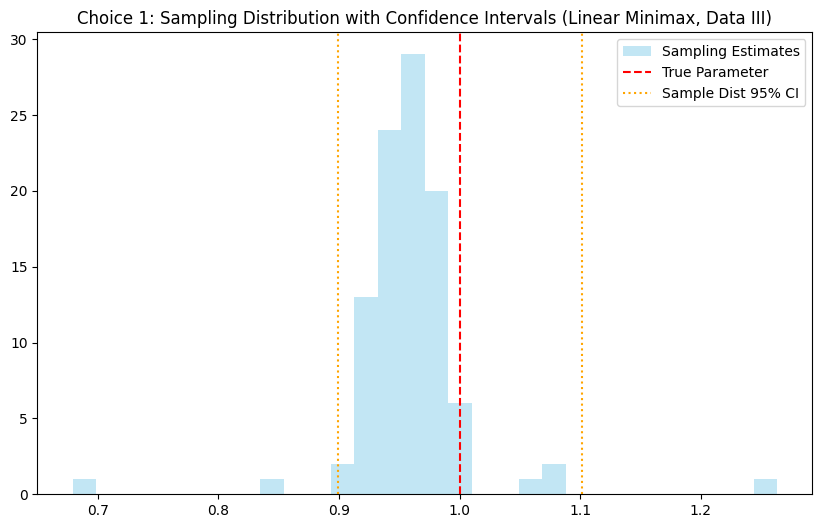

In [258]:
plt.figure(figsize=(10, 6))
plt.hist(pes_mini, bins=30, alpha=0.5, color='skyblue', label='Sampling Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(pes_mini, se_mini)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1, label=label)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 1: Sampling Distribution with Confidence Intervals (Linear Minimax, Data III)')

plt.legend()
plt.show()

In [259]:
pes_mini = []
se_mini = []
coverage_flags = []
N = 5216
n = 200

for s in range(0, 100):  # outer loop: sample subsets
    np.random.seed(s)
    i = np.random.choice(range(5216), 200, replace=False)
    X_0s = np.array(X_filter[i])
    W_0s = np.array(W[i])
    Y1_0s = np.array(Y1[i])
    Y0_0s = np.array(Y0[i])

    # construct psi (basis functions)
    psi = np.zeros((len(X_0s), 3))
    psi[:, 0] = 1
    psi[:, 1] = X_0s
    psi[:, 2] = X_0s ** 2

    # build design matrix A and vector b
    n = len(X_0s)
    A = np.zeros((6, n))
    b = np.zeros(6)
    for k in range(n):
        A[:3, k] = psi[k] * (1 - W_0s[k])
        A[3:, k] = psi[k] * W_0s[k]
        b[:3] += -psi[k]
        b[3:] += psi[k]
    A = A / n
    b = b / n

    # solve minimax gamma
    lambda_reg =    7.310044345532168e-07
    AT_A = np.dot(A.T, A) + lambda_reg * np.eye(A.shape[1])
    AT_b = np.dot(A.T, b)
    gamma_mini = np.linalg.solve(AT_A, AT_b)

    # compute IPW estimate
    Y_fulls = W_0s * Y1_0s + (1 - W_0s) * Y0_0s
    ipw_estimate = np.mean(gamma_mini * Y_fulls)
    pes_mini.append(ipw_estimate)

    # compute variance estimator
    y_preds = y_pred[i]
    v_sum = gamma_mini**2 * (Y_fulls - y_preds) ** 2
    v_hat = (1 / N**2) * np.sum(v_sum)
    se_hat = np.sqrt(v_hat)
    se_mini.append(se_hat)


# convert to arrays and summarize
pes_mini = np.array(pes_mini)
se_mini = np.array(se_mini)
exppes = np.mean(pes_mini)
samplestd = np.std(pes_mini)
true_arm_l, true_arm_r = 1 - 1.96*samplestd, 1+1.96*samplestd
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes_mini]
coverage = np.mean(coverage_flags)
expstd = np.mean(se_mini)
true_arm_l, true_arm_r = 1-1.96 * np.std(pes_mini), 1 + 1.96 * np.std(pes_mini)

print('coverage:', coverage)
print('sample std:', samplestd)
print('expected std:', expstd)
print('expected pes:', exppes)


coverage: 0.94
sample std: 1.7090912217752716
expected std: 15.628386265095179
expected pes: 0.9710351204675095


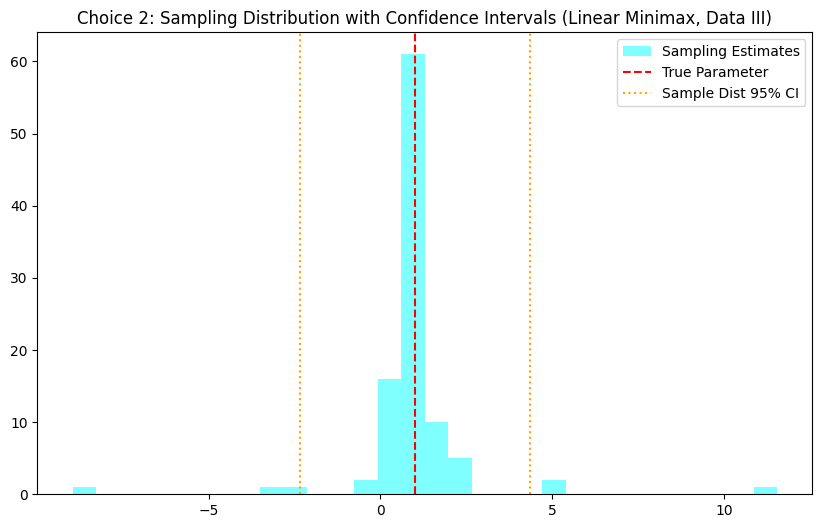

In [260]:
plt.figure(figsize=(10, 6))
plt.hist(pes_mini, bins=30, alpha=0.5, color='cyan', label='Sampling Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(pes_mini, se_mini)):
#     label = 'Point Estimate Var' if i == 0 else None
#     plt.errorbar(x=point_est, y=i/12, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1, label=label)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 2: Sampling Distribution with Confidence Intervals (Linear Minimax, Data III)')

plt.legend()
plt.show()

In [261]:
# p selection
# p = -1, -1/2, 0, 1/2, 1, 3/2, 2

rmsev = []
biasv = []
p_mini = 200
sigma = 1
Bsv = []
coveragev = []

for p in [-1, -3/4, -1/2, -1/4, 0, 1/4, 1/3]:
    pes_mini = []
    se_mini = []
    coverage_flags = []
    Bs = p_mini**p
    Bsv.append(Bs)

    lamb = sigma**2/(Bs**2*200**2)
    for s in range(0, 100):  # outer loop: sample subsets
        np.random.seed(s)
        i = np.random.choice(range(5216), 200, replace=False)
        X_0s = np.array(X_filter[i])
        W_0s = np.array(W[i])
        Y1_0s = np.array(Y1[i])
        Y0_0s = np.array(Y0[i])

    # construct psi (basis functions)
        psi = np.zeros((len(X_0s), 3))
        psi[:, 0] = 1
        psi[:, 1] = X_0s
        psi[:, 2] = X_0s ** 2

    # build design matrix A and vector b
        n = len(X_0s)
        A = np.zeros((6, n))
        b = np.zeros(6)
        for k in range(n):
            A[:3, k] = psi[k] * (1 - W_0s[k])
            A[3:, k] = psi[k] * W_0s[k]
            b[:3] += -psi[k]
            b[3:] += psi[k]
        A = A / n
        b = b / n

    # solve minimax gamma
        lambda_reg = lamb
        AT_A = np.dot(A.T, A) + lambda_reg * np.eye(A.shape[1])
        AT_b = np.dot(A.T, b)
        gamma_mini = np.linalg.solve(AT_A, AT_b)

    # compute IPW estimate
        Y_fulls = W_0s * Y1_0s + (1 - W_0s) * Y0_0s
        ipw_estimate = np.mean(gamma_mini * Y_fulls)
        pes_mini.append(ipw_estimate)

    # compute variance estimator
        y_preds = y_pred[i]
        v_sum = gamma_mini**2 * (Y_fulls - y_preds) ** 2
        v_hat = (1 / N**2) * np.sum(v_sum)
        se_hat = np.sqrt(v_hat)
        se_mini.append(se_hat)


# convert to arrays and summarize
    pes_mini = np.array(pes_mini)
    se_mini = np.array(se_mini)
    exppes = np.mean(pes_mini)
    samplestd = np.std(pes_mini)
    true_arm_l, true_arm_r = 1 - 1.96*samplestd, 1+1.96*samplestd
    coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes_mini]
    coverage = np.mean(coverage_flags)
    expstd = np.mean(se_mini)
    true_arm_l, true_arm_r = 1-1.96 * np.std(pes_mini), 1 + 1.96 * np.std(pes_mini)
    rmse = np.sqrt(np.mean((pes_mini - 1)**2))
    bias = np.abs(np.mean(pes_mini - 1))



    print('k:', p)
    print('lambda:', lamb)
    print('coverage:', coverage)
    print('sample std:', samplestd)
    print('expected pes:', exppes)
    print('bias:', bias)
    print('bias/rmse:', bias/rmse)
    print('Bs:', Bs)
    print('---')

    rmsev.append(rmse)
    biasv.append(bias)
    coveragev.append(coverage)

    


k: -1
lambda: 1.0
coverage: 0.52
sample std: 0.015720442409307235
expected pes: 0.968744421641117
bias: 0.0312555783588831
bias/rmse: 0.8933653741272561
Bs: 0.005
---
k: -0.75
lambda: 0.07071067811865477
coverage: 0.52
sample std: 0.015760650567269403
expected pes: 0.9688674888852088
bias: 0.03113251111479108
bias/rmse: 0.8921877180123176
Bs: 0.018803015465431967
---
k: -0.5
lambda: 0.005
coverage: 0.52
sample std: 0.015777333465418927
expected pes: 0.9687743762552715
bias: 0.031225623744728415
bias/rmse: 0.8925382365497785
Bs: 0.07071067811865475
---
k: -0.25
lambda: 0.0003535533905932737
coverage: 0.49
sample std: 0.016354408641225532
expected pes: 0.9660577165961193
bias: 0.03394228340388076
bias/rmse: 0.9008789299111974
Bs: 0.26591479484724945
---
k: 0
lambda: 2.5e-05
coverage: 0.97
sample std: 0.051629418015813194
expected pes: 0.9599296528801672
bias: 0.04007034711983261
bias/rmse: 0.6131216471219593
Bs: 1
---
k: 0.25
lambda: 1.7677669529663689e-06
coverage: 0.98
sample std: 8.00

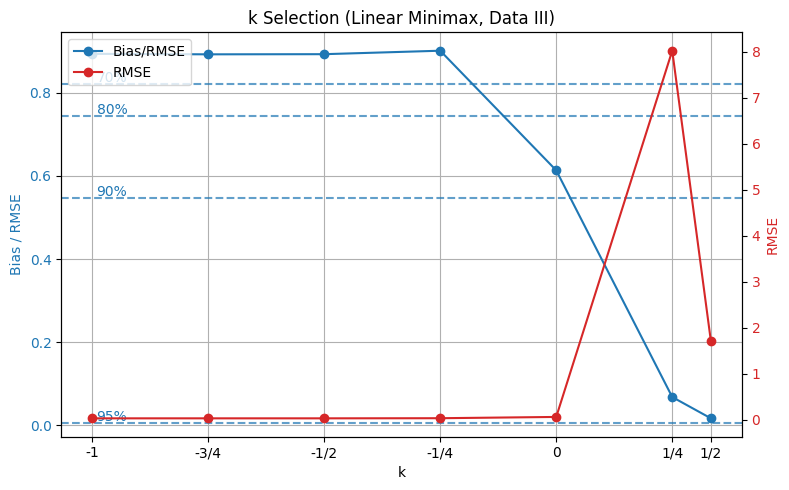

In [262]:
# plt.plot(np.log(Bsv), rmsev, marker='o', label='RMSE')
# plt.plot(np.log(Bsv), biasv/rmse, marker='o', label='Bias/RMSE')
# plt.title('k selection (Linear Minimax, Data III)')
# plt.xticks(np.log(Bsv))
# plt.grid()
# plt.legend()
# plt.show()

biasoverrmse = np.array(biasv)/np.array(rmsev)  

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Bias / RMSE
color1 = 'tab:blue'
line1, = ax1.plot(np.log(Bsv), biasoverrmse, marker='o', color=color1, label='Bias/RMSE')
ax1.set_xlabel('k')
ax1.set_ylabel('Bias / RMSE', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# X-axis ticks
ax1.set_xticks(np.log(Bsv))
ax1.set_xticklabels(['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2'])

# Add horizontal lines for coverage levels
for label, threshold in coverage_levels.items():
    ax1.axhline(y=threshold, color=color1, linestyle='--', alpha=0.7)
    ax1.text(np.log(Bsv[0]) + 0.05, threshold+0.015, label,
             va='center', ha='left', fontsize=10, color=color1)

# Secondary y-axis for RMSE
ax2 = ax1.twinx()
color2 = 'tab:red'
line2, = ax2.plot(np.log(Bsv), rmsev, marker='o', color=color2, label='RMSE')
ax2.set_ylabel('RMSE', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Title, grid, and layout
plt.title('k Selection (Linear Minimax, Data III)')
ax1.grid(True)
plt.tight_layout()
plt.show()

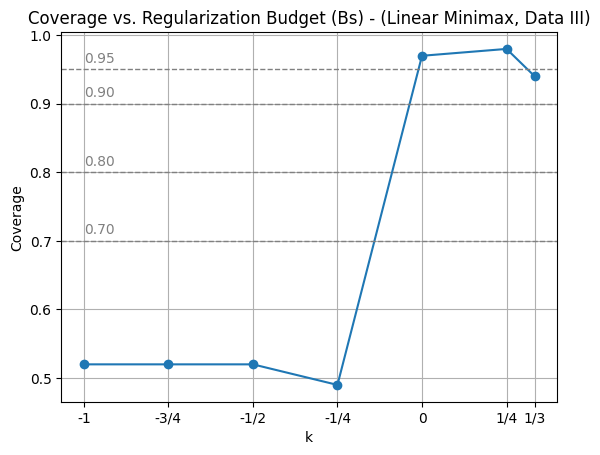

In [263]:
# coverage
plt.plot(np.log(Bsv), coveragev, marker='o', label='Coverage')
# Add horizontal reference lines at common confidence levels
for level in [0.7, 0.8, 0.9, 0.95]:
    plt.axhline(y=level, color='gray', linestyle='--', linewidth=1)
    plt.text(np.log(Bsv)[0], level + 0.01, f'{level:.2f}', color='gray')

# Customize the plot
plt.xlabel('k')
plt.ylabel('Coverage')
plt.title('Coverage vs. Regularization Budget (Bs) - (Linear Minimax, Data III)')
plt.grid(True)
plt.xticks(np.log(Bsv), ['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/3'])
plt.show()

## RBF

In [264]:
n = 5216
sw = 1
s = np.mean(X_0)
sigma2 = 0.25
K_XX_masked, K_Xdiff = kernel_with_masking(W_0, X_0, sw, s, sigma=sigma2)
I = np.eye(K_XX_masked.shape[0])
lambda_reg = 1

gamma_rbf = (np.linalg.solve(K_XX_masked + lambda_reg * I, (K_Xdiff))).flatten()
Y_fulls = W_0 * Y1_0 + (1 - W_0) * Y0_0
ipw_rbf = np.mean(gamma_rbf* Y_fulls)
print("IPW estimate:", ipw_rbf)

IPW estimate: 0.9855142389828255


In [265]:
I = np.eye(K_XX_masked.shape[0])
lambda_reg = 0.07071067811865477

gamma_rbf2 = (np.linalg.solve(K_XX_masked + lambda_reg * I, (K_Xdiff))).flatten()
Y_fulls = W_0 * Y1_0 + (1 - W_0) * Y0_0
ipw_rbf2 = np.mean(gamma_rbf2* Y_fulls)
print("IPW estimate:", ipw_rbf2)

IPW estimate: 1.0041149211878766


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/2054927774.py:9: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/2054927774.py:10: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


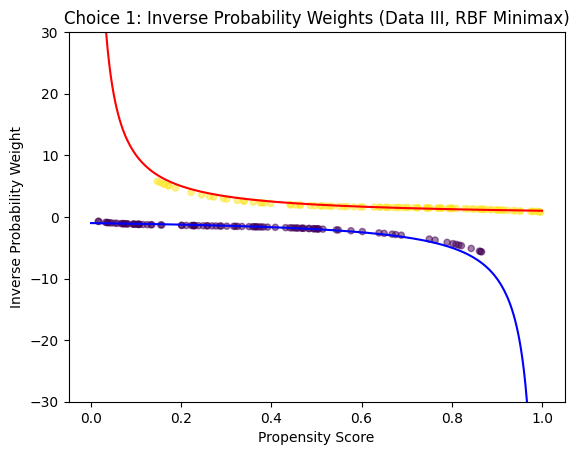

In [266]:
# x = np.array(range(0,7000))
# plt.scatter(X_0, gamma_rbf, c = W_0,alpha = .5, s = 10)
# plt.plot(x, 1/(propensity_score(x)), color = 'red')
# plt.plot(x, 1/((propensity_score(x)-1)), color = 'blue')
# plt.title('Inverse Probability Weights (Data III, RBF Minimax)')
# plt.ylim(-40,40)

x_vals = np.linspace(1,0, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, gamma_rbf, c = W_0,alpha = .5, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Choice 1: Inverse Probability Weights (Data III, RBF Minimax)')
plt.ylim(-30, 30)
plt.show()

/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/956489564.py:2: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1855/956489564.py:3: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


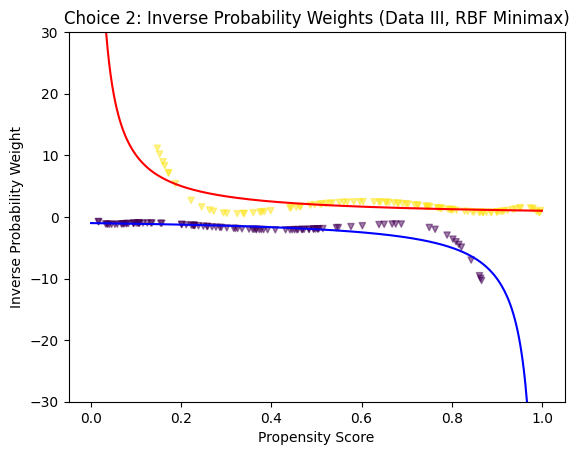

In [267]:

x_vals = np.linspace(1,0, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, gamma_rbf2, c = W_0,alpha = .5, s = 20, marker='v')
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Choice 2: Inverse Probability Weights (Data III, RBF Minimax)')
plt.ylim(-30, 30)
plt.show()

In [268]:
pes_rbf = []
se_rbf = []
coverage_flags = []
N = 5216
n = 200
sigma2 = 0.25
lambda_reg = 1

for s in range(100):  # outer loop: sample subsets
    np.random.seed(s)
    i = np.random.choice(range(N), n, replace=False)
    X_0s = np.array(X_filter[i])
    W_0s = np.array(W[i])
    Y1_0s = np.array(Y1[i])
    Y0_0s = np.array(Y0[i])
    y_preds = y_pred[i]

    # RBF kernel matrix and target vector
    sw = 1
    s_avg = np.mean(X_0s)
    K_XX_masked, K_Xdiff = kernel_with_masking(W_0s, X_0s, sw, s_avg, sigma=sigma2)
    I = np.eye(n)

    # solve for gamma using ridge regularization
    gamma_rbf = np.linalg.solve(K_XX_masked + lambda_reg * I, K_Xdiff).flatten()

    # IPW estimate
    Y_fulls = W_0s * Y1_0s + (1 - W_0s) * Y0_0s
    ipw_estimate = np.mean(gamma_rbf * Y_fulls)
    pes_rbf.append(ipw_estimate)

    # Variance estimate
    v_sum = gamma_rbf**2 * (Y_fulls - y_preds) ** 2
    v_hat = (1 / N**2) * np.sum(v_sum)
    se_hat = np.sqrt(v_hat)
    se_rbf.append(se_hat)

# Summarize sampling distribution
pes_rbf = np.array(pes_rbf)
se_rbf = np.array(se_rbf)
exppes = np.mean(pes_rbf)
samplestd = np.std(pes_rbf)
true_arm_l, true_arm_r = 1 - 1.96 * samplestd, 1 + 1.96 * samplestd
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes_rbf]
coverage = np.mean(coverage_flags)
expstd = np.mean(se_rbf)

print('coverage:', coverage)
print('sample std:', samplestd)
print('expected std:', expstd)
print('expected pes:', exppes)

coverage: 0.95
sample std: 0.02279319181929099
expected std: 0.05407974438004185
expected pes: 0.9947929534007707


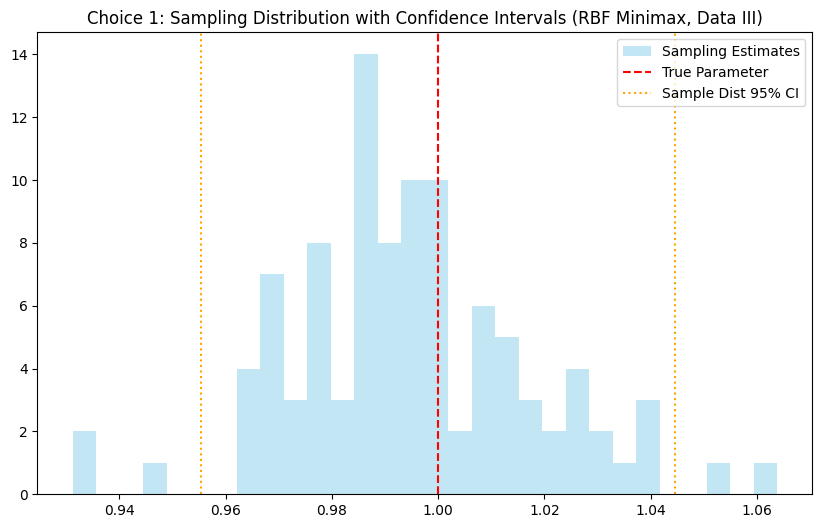

In [269]:
plt.figure(figsize=(10, 6))
plt.hist(pes_rbf, bins=30, alpha=0.5, color='skyblue', label='Sampling Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')


plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 1: Sampling Distribution with Confidence Intervals (RBF Minimax, Data III)')

plt.legend()
plt.show()

In [270]:
pes_rbf = []
se_rbf = []
coverage_flags = []
N = 5216
n = 200
sigma2 = 0.25
lambda_reg = 0.07071067811865477

for s in range(100):  # outer loop: sample subsets
    np.random.seed(s)
    i = np.random.choice(range(N), n, replace=False)
    X_0s = np.array(X_filter[i])
    W_0s = np.array(W[i])
    Y1_0s = np.array(Y1[i])
    Y0_0s = np.array(Y0[i])
    y_preds = y_pred[i]

    # RBF kernel matrix and target vector
    sw = 1
    s_avg = np.mean(X_0s)
    K_XX_masked, K_Xdiff = kernel_with_masking(W_0s, X_0s, sw, s_avg, sigma=sigma2)
    I = np.eye(n)

    # solve for gamma using ridge regularization
    gamma_rbf = np.linalg.solve(K_XX_masked + lambda_reg * I, K_Xdiff).flatten()

    # IPW estimate
    Y_fulls = W_0s * Y1_0s + (1 - W_0s) * Y0_0s
    ipw_estimate = np.mean(gamma_rbf * Y_fulls)
    pes_rbf.append(ipw_estimate)

    # Variance estimate
    v_sum = gamma_rbf**2 * (Y_fulls - y_preds) ** 2
    v_hat = (1 / N**2) * np.sum(v_sum)
    se_hat = np.sqrt(v_hat)
    se_rbf.append(se_hat)

# Summarize sampling distribution
pes_rbf = np.array(pes_rbf)
se_rbf = np.array(se_rbf)
exppes = np.mean(pes_rbf)
samplestd = np.std(pes_rbf)
true_arm_l, true_arm_r = 1 - 1.96 * samplestd, 1 + 1.96 * samplestd
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes_rbf]
coverage = np.mean(coverage_flags)
expstd = np.mean(se_rbf)

print('coverage:', coverage)
print('sample std:', samplestd)
print('expected std:', expstd)
print('expected pes:', exppes)

coverage: 0.82
sample std: 0.014242599079783261
expected std: 0.06297888551627213
expected pes: 1.016172695766689


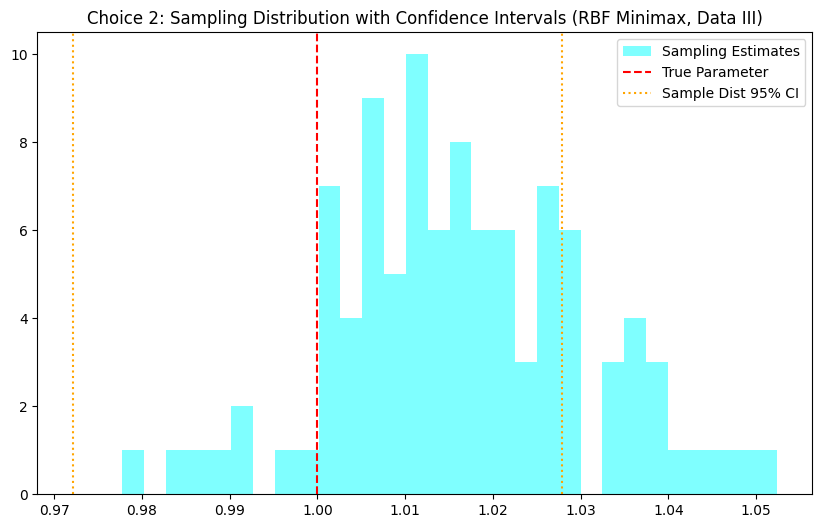

In [271]:
plt.figure(figsize=(10, 6))
plt.hist(pes_rbf, bins=30, alpha=0.5, color='cyan', label='Sampling Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')


plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 2: Sampling Distribution with Confidence Intervals (RBF Minimax, Data III)')

plt.legend()
plt.show()

In [272]:
# p selection
rmsev = []
biasv = []
p_mini = 200

sigma = 1
Bsv = []
coveragev = []


for p in [-1, -3/4, -1/2, -1/4, 0, 1/4, 1/2]:
    pes_mini = []
    se_mini = []
    coverage_flags = []
    Bs = p_mini**p
    Bsv.append(Bs)
    lamb = sigma**2/(Bs**2*200**2)
    sigma2 = 0.25 

    for s in range(100):  
        np.random.seed(s)
        i = np.random.choice(range(5216), 200, replace=False)
        X_0s = np.array(X_filter[i])
        W_0s = np.array(W[i])
        Y1_0s = np.array(Y1[i])
        Y0_0s = np.array(Y0[i])
        y_preds = y_pred[i]

        sw = 1
        s_avg = np.mean(X_0s)
        K_XX_masked, K_Xdiff = kernel_with_masking(W_0s, X_0s, sw, s_avg, sigma=sigma2)
        I = np.eye(K_XX_masked.shape[0])
        gamma_rbf = np.linalg.solve(K_XX_masked + lamb * I, K_Xdiff).flatten()

        # IPW estimate
        Y_fulls = W_0s * Y1_0s + (1 - W_0s) * Y0_0s
        ipw_estimate = np.mean(gamma_rbf * Y_fulls)
        pes_mini.append(ipw_estimate)

        # Variance estimate
        v_sum = gamma_rbf**2 * (Y_fulls - y_preds) ** 2
        v_hat = (1 / len(W_0s)**2) * np.sum(v_sum)
        se_hat = np.sqrt(v_hat)
        se_mini.append(se_hat)

    # Summarize results
    pes_mini = np.array(pes_mini)
    se_mini = np.array(se_mini)
    exppes = np.mean(pes_mini)
    samplestd = np.std(pes_mini)
    true_arm_l, true_arm_r = 1 - 1.96*samplestd, 1 + 1.96*samplestd
    coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes_mini]
    coverage = np.mean(coverage_flags)
    expstd = np.mean(se_mini)
    rmse = np.sqrt(np.mean((pes_mini - 1)**2))
    bias = np.abs(np.mean(pes_mini - 1))
    print('k:', p)
    print('lambda:', lamb)
    print('coverage:', coverage)
    print('sample std:', samplestd)
    print('expected pes:', exppes)
    print('rmse:', rmse)
    print('bias:', bias)
    print('bias/rmse:', bias/rmse)
    print('Bs:', Bs)
    print('---')

    rmsev.append(rmse)
    biasv.append(bias)
    coveragev.append(coverage)


k: -1
lambda: 1.0
coverage: 0.95
sample std: 0.02279319181929099
expected pes: 0.9947929534007707
rmse: 0.02338039622413482
bias: 0.005207046599229166
bias/rmse: 0.22270993824536225
Bs: 0.005
---
k: -0.75
lambda: 0.07071067811865477
coverage: 0.82
sample std: 0.014242599079783261
expected pes: 1.016172695766689
rmse: 0.021550121041639857
bias: 0.016172695766689175
bias/rmse: 0.7504689062042741
Bs: 0.018803015465431967
---
k: -0.5
lambda: 0.005
coverage: 0.7
sample std: 0.01033320062105782
expected pes: 1.016443563576272
rmse: 0.019420757404435374
bias: 0.016443563576272073
bias/rmse: 0.8467004264476646
Bs: 0.07071067811865475
---
k: -0.25
lambda: 0.0003535533905932737
coverage: 0.7
sample std: 0.008286268634527997
expected pes: 1.0142896337794083
rmse: 0.01651834983989523
bias: 0.01428963377940822
bias/rmse: 0.8650763495089442
Bs: 0.26591479484724945
---
k: 0
lambda: 2.5e-05
coverage: 0.66
sample std: 0.00696291146753719
expected pes: 1.0126902062678786
rmse: 0.014474925603472613
bias:

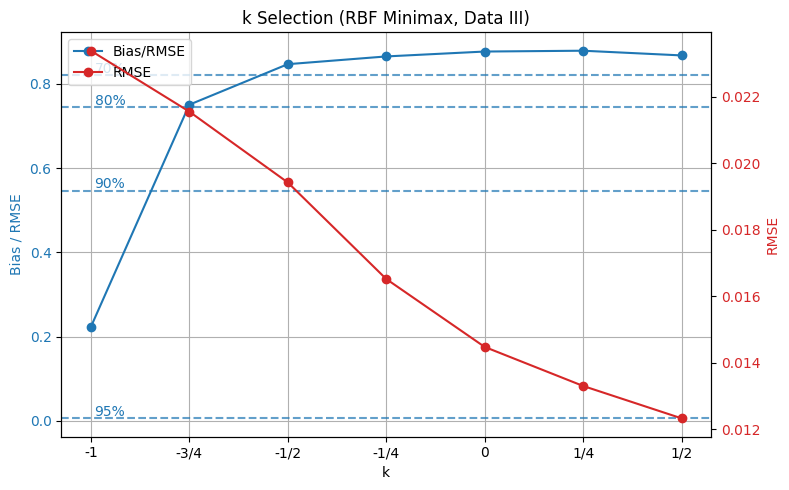

In [273]:
# plt.plot(np.log(Bsv), rmsev, marker='o', label='RMSE')
# plt.plot(np.log(Bsv), biasv/rmse, marker='o', label='Bias/RMSE')
# plt.title('k selection (RBF Minimax, Data III)')
# plt.xticks(np.log(Bsv))
# plt.grid()
# plt.legend()
# plt.show()


biasoverrmse = np.array(biasv)/np.array(rmsev)  

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Bias / RMSE
color1 = 'tab:blue'
line1, = ax1.plot(np.log(Bsv), biasoverrmse, marker='o', color=color1, label='Bias/RMSE')
ax1.set_xlabel('k')
ax1.set_ylabel('Bias / RMSE', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# X-axis ticks
ax1.set_xticks(np.log(Bsv))
ax1.set_xticklabels(['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2'])

# Add horizontal lines for coverage levels
for label, threshold in coverage_levels.items():
    ax1.axhline(y=threshold, color=color1, linestyle='--', alpha=0.7)
    ax1.text(np.log(Bsv[0]) + 0.05, threshold+0.015, label,
             va='center', ha='left', fontsize=10, color=color1)

# Secondary y-axis for RMSE
ax2 = ax1.twinx()
color2 = 'tab:red'
line2, = ax2.plot(np.log(Bsv), rmsev, marker='o', color=color2, label='RMSE')
ax2.set_ylabel('RMSE', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Title, grid, and layout
plt.title('k Selection (RBF Minimax, Data III)')
ax1.grid(True)
plt.tight_layout()
plt.show()

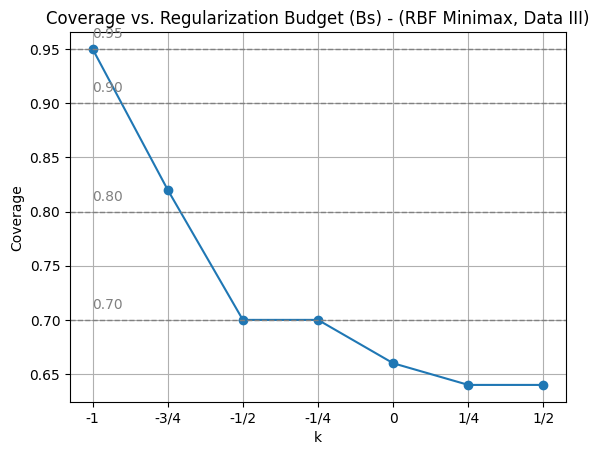

In [274]:
#coverage
plt.plot(np.log(Bsv), coveragev, marker='o', label='Coverage')
# Add horizontal reference lines at common confidence levels
for level in [0.7, 0.8, 0.9, 0.95]:
    plt.axhline(y=level, color='gray', linestyle='--', linewidth=1)
    plt.text(np.log(Bsv)[0], level + 0.01, f'{level:.2f}', color='gray')
# Customize the plot
plt.xlabel('k')
plt.ylabel('Coverage')
plt.title('Coverage vs. Regularization Budget (Bs) - (RBF Minimax, Data III)')
plt.grid(True)
plt.xticks(np.log(Bsv), ['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2'])
plt.show()